# M√©todos basados en datos

Los m√©todos basados en datos, tambi√©n denominados m√©todos estad√≠sticos, se clasifican en bivariados y multivariados. Como caracter√≠stica tienen que es indispensable contar con un inventario de movimientos en masa, no es posible implementar un m√©todo estad√≠stico para evaluar la susceptibilidad por movimientos en masa sin un inventario. A continuaci√≥n se presenta cada uno de estos m√©todos.

## Bivariados
En los m√©todos bivariados cada mapa factor (geolog√≠a, pendiente, coberturas, etc) es combinado con el inventario de movimientos en masa, para obtener los pesos de las clases que conforman las variables, basados generalmente en densidad de movimientos en masa. Los m√©todos estad√≠sticos bivariados son una buena herramienta de aprendizaje para el analista encontrar qu√© factores o combinaci√≥n de factores juegan un papel importante en la ocurrencia de movimientos en masa. 

Como se mencion√≥ anteriormente, estos m√©todos est√°n basados en la asociaci√≥n observada entre la distribuci√≥n de los movimientos en masa y cada clase de la variable, lo que exige que cada variable sea transforamda a una variable categ√≥rica dividida por clases. De esta misma forma los m√©todos bivariados s√≥lo permiten asignar peso a las clases y no a las variables, por lo que todas las variables tienen una importancia igual sobre la ocurrencia de movimientos en masa. Considerando esta desventaja, es muy com√∫n combinar los m√©todos estad√≠sticos bivariados con m√©todos heur√≠sticos como AHP para poder asignar peso a las variables.

Existe una gran cantidad de m√©todos estad√≠sticos bivariados, los cuales se subdividen esencialmente en m√©todos basados en la densidad del n√∫mero de movimientos en masa en cada clase (*Frequency ratio*, *Statistical index*), y los m√©todos basados en el teorema de Bayes (*Weight-of-evidence*, *Evidential belief function*,  *Certainty factor*).

### *Frequency ratio model* (*Likelihood*)
Este m√©todo, al igual que todos los m√©todos bivariados, calcula un peso para cada clase en la cual es dividida cada variable. En este caso el peso de la clase n ($w_n$) se calcula dividiendo la relaci√≥n de la ocurrencia de movimientos en masa ($L_r$) por la relaci√≥n del √°rea de la clase ($A_r$):

$w_n = \frac{L_r}{A_r}$

Donde $L_r$ es el porcentaje de movimientos en masa total que contiene la clase $n$, y $A_r$ es el porcentaje del √°rea total de representa dicha clase:

$L_r = \frac{L_{clase}}{L_{total}}$

$A_r = \frac{A_{clase}}{A_{total}}$

Finalmente, la susceptibilidad de una celda es igual a la sumatoria del peso de cada clase ($w$) a la que pertenece en cada variable:

$S^n = \sum w = w_{pendiente} + w_{geologia} + w_{coberturas} + ...w_{n} $

:::{figure-md} likehood
<img src="https://www.researchgate.net/profile/Jangwon-Suh-3/publication/303875920/figure/fig1/AS:371153064480768@1465501194778/Example-for-calculating-frequency-ratio-using-raster-grids-modified-from-Oh-et-al.png" alt="likehood" width="600px">

M√©todo de *Frequency ratio*. Tomado de Suh et al. (2015)
:::

#### *Python*

En el presente ejemplo, y solo con prop√≥sitos pedag√≥gicos, se utilizar√°n solo tres variables (pendiente, geologia, aspecto) pero el procedimiento se√±alado se debera utilizar para todas las variables incorporadas en el modelo de susceptibilidad.

Inicialmente se procede a importar las librer√≠as a utilizar:

In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

A continuaci√≥n se importa el inventario de movimientos en masa, as√≠ como los mapas de las variables predictoras a utilizar:

(910801,)

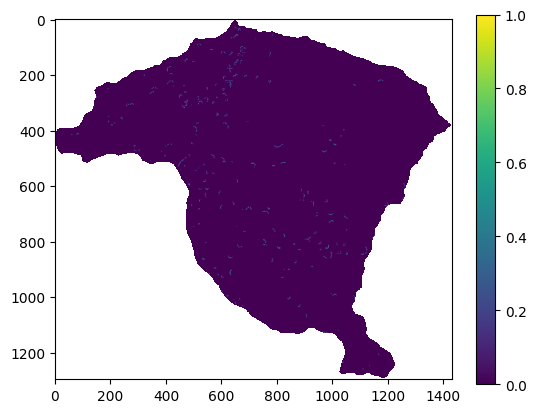

In [2]:
raster = rio.open('https://github.com/edieraristizabal/Libro_cartoGeotecnia/blob/master/data/miel/Inventario_MenM.tif?raw=true')
inventario=raster.read(1)
raster_mask = rio.open('https://github.com/edieraristizabal/Libro_cartoGeotecnia/blob/master/data/miel/Pendiente.tif?raw=true')
msk=raster_mask.read_masks(1)
msk=np.where(msk==255,1,np.nan)
inventario=msk*inventario
inventario_vector=inventario.ravel()
inventario_vector_MenM=inventario_vector[~np.isnan(inventario_vector)]
plt.imshow(inventario)
plt.colorbar()
inventario_vector_MenM.shape

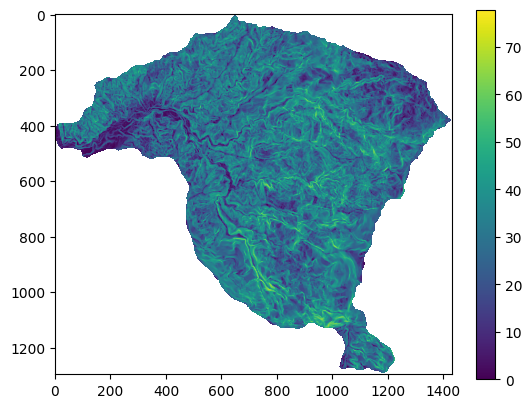

In [3]:
raster = rio.open('https://github.com/edieraristizabal/Libro_cartoGeotecnia/blob/master/data/miel/Pendiente.tif?raw=true')
pendiente=raster.read(1)
pendiente=np.where(pendiente<0,np.nan,pendiente)
plt.imshow(pendiente);
plt.colorbar();
pendiente_vector=pendiente.ravel()
pendiente_vector_MenM=pendiente_vector[~np.isnan(pendiente_vector)]

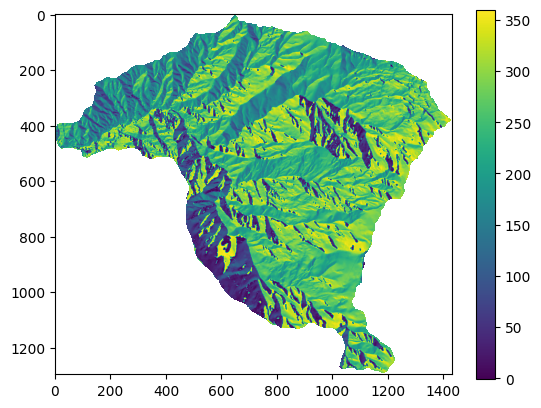

In [4]:
raster = rio.open('https://github.com/edieraristizabal/Libro_cartoGeotecnia/blob/master/data/miel/Aspecto.tif?raw=true')
aspecto=raster.read(1)
aspecto=np.where(aspecto<-100,np.nan,aspecto)
aspecto_vector=aspecto.ravel()
aspecto_vector_MenM=aspecto_vector[~np.isnan(aspecto_vector)]
plt.imshow(aspecto)
plt.colorbar()

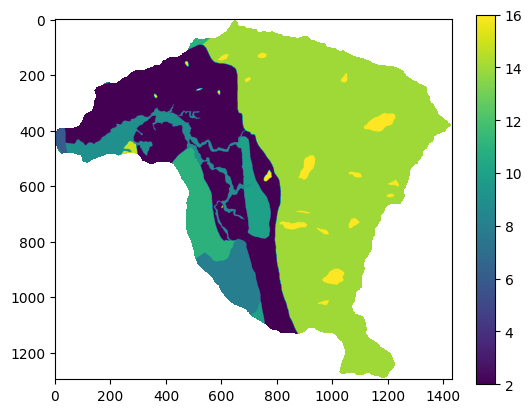

In [5]:
raster = rio.open('https://github.com/edieraristizabal/Libro_cartoGeotecnia/blob/master/data/miel/Geologia_Superficial.tif?raw=true')
geologia=raster.read(1)
geologia=np.where(geologia<0,np.nan,geologia)
geologia_vector=geologia.ravel()
geologia_vector_MenM=geologia_vector[~np.isnan(geologia_vector)]
plt.imshow(geologia)
plt.colorbar();

Para implementar todos lo m√©todos estad√≠sticos bivariados se deben conocer para cada clase de las variables, el n√∫mero de celdas que pertenecen a dicha clase y el n√∫mero de celdas con MenM.

A continuaci√≥n se presenta el procedimiento para el mapa de pendiente, el cual es una variable continua. Como se mencion√≥ anteriormente en los metodos estad√≠sticos bivariados se deben transformar las variables continuas a categ√≥ricas. En este caso el mapa de pendientes se convierte a 5 clases [0-10, 10-20, 20-30, 30-35, >35]. 

Para realizar este procedimiento se utiliza el vector que se gener√≥ con el mapa de pendiente, y se convierte a una serie de Pandas, de tal forma que permita iterar.

In [11]:
pendiente_serie=pd.Series(pendiente_vector_MenM)
ap=bp=cp=dp=ep=0
for row in pendiente_serie:
        if (0 <= row) & (row < 10):
          ap+=1
        elif (10 <= row) & (row < 20):
          bp+=1
        elif (20 <= row) & (row < 30):
          cp+=1
        elif (30 <= row) & (row < 35):
          dp+=1
        if (row>=35):
          ep+=1

total=ap+bp+cp+dp+ep
print("total:", totalp,ap,bp,cp,dp,ep)

pendienteconMenM=pendiente_vector_MenM*inventario_vector_MenM
ap1=bp1=cp1=dp1=ep1=0
for row in pendienteconMenM:
        if (0 < row) & (row < 10):
          ap1+=1
        elif (10 <= row) & (row < 20):
          bp1+=1
        elif (20 <= row) & (row < 30):
          cp1+=1
        elif (30 <= row) & (row < 35):
          dp1+=1
        if (row>=35):
          ep1+=1

total1=ap1+bp1+cp1+dp1+ep1
print("total1:", total1p,ap1,bp1,cp1,dp1,ep1)

total: 910801 53805 138684 279488 158011 280813
total1: 1620 13 108 411 301 787


Ahora se calcula el *Frequency ratio* para cada clase a partir de los valores estimados previamente:

In [12]:
w_a=(ap1/total1)/(ap/total)
w_b=(bp1/total1)/(bp/total)
w_c=(cp1/total1)/(cp/total)
w_d=(dp1/total1)/(dp/total)
w_e=(ep1/total1)/(ep/total)
print(w_a,w_b,w_c,w_d,w_e)

0.13584047790317347 0.4378303673579264 0.826774627307924 1.0709955300033418 1.5756726885555798


Finalmente se reclasifica el mapa, asign√°ndole a cada clase el valor del *Frequency ratio* calculado:

[0.13584048 0.43783036 0.82677466 1.0709956  1.5756727         nan]


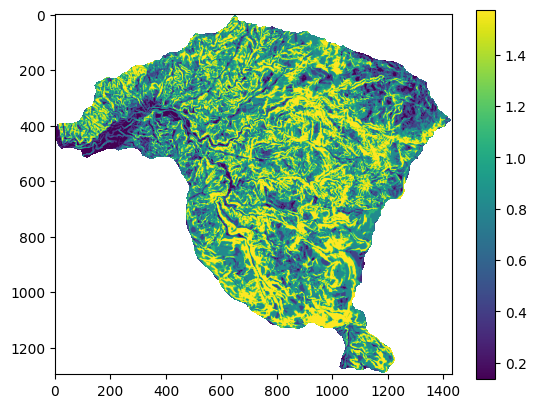

In [13]:
pendiente_c=np.where ( (np.logical_and (pendiente>=0, pendiente<10 )),w_a,pendiente )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),w_b,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=20, pendiente_c<30 )),w_c,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=30, pendiente_c<35 )),w_d,pendiente_c )
pendiente_c=np.where ( pendiente_c>=35,w_e,pendiente_c )

plt.imshow(pendiente_c)
plt.colorbar()
print(np.unique(pendiente_c));

Ahora se realiza el mismo procedimiento para la variable *aspecto*, la cual tambien es continua, en este caso se divide en 4 clases [0-90, 90-180, 180-270, 270-360]:

total: 909599 151110 128456 306544 323489
total1: 1620 271 401 469 479
w: 1.0082879326727077 1.7550862446438882 0.8601783487146872 0.8325004563476865
[-1.          0.83250046  0.86017835  1.0082879   1.7550863          nan]


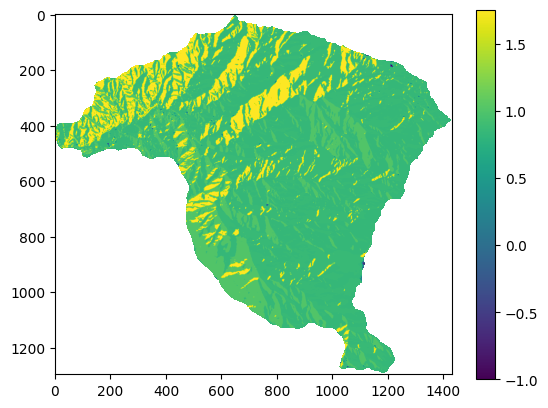

In [15]:
aspecto_serie=pd.Series(aspecto_vector_MenM)
aa=ba=ca=da=0
for row in aspecto_serie:
        if (0 <= row) & (row < 90):
          aa+=1
        elif (90 <= row) & (row < 180):
          ba+=1
        elif (180 <= row) & (row < 270):
          ca+=1
        if (row>=270):
          da+=1

totala=aa+ba+ca+da
print("total:", totala,aa,ba,ca,da)

aspectoconMenM=aspecto_vector_MenM*inventario_vector_MenM
aa1=ba1=ca1=da1=0
for row in aspectoconMenM:
        if (0 < row) & (row < 90):
          aa1+=1
        elif (90 <= row) & (row < 180):
          ba1+=1
        elif (180 <= row) & (row < 270):
          ca1+=1
        if (row>=270):
          da1+=1

total1a=aa1+ba1+ca1+da1
print("total1:", total1a,aa1,ba1,ca1,da1)

w_a=(aa1/total1)/(aa/total)
w_b=(ba1/total1)/(ba/total)
w_c=(ca1/total1)/(ca/total)
w_d=(da1/total1)/(da/total)
print("w:", w_a,w_b,w_c,w_d)

aspecto_c=np.where ( (np.logical_and (aspecto>=0, aspecto<90 )),w_a,aspecto )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=90, aspecto_c<180 )),w_b,aspecto_c )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=180, aspecto_c<270 )),w_c,aspecto_c )
aspecto_c=np.where ( aspecto_c>=270,w_d,aspecto_c )

plt.imshow(aspecto_c)
plt.colorbar()
print(np.unique(aspecto_c));

Y el mismo procedimiento para la variable *geologia*, la cual es categ√≥rica por lo cual ligeramente var√≠a el procedimiento.

total 910801 237383 169 3060 32352 37658 22405 41720 515621 1850 18583
total1 1620 612 0 0 98 0 43 118 736 13 0
w: 1.4494735418196658 0.0 0.0 1.703073635991745 0.0 1.0790262039172254 1.5901796515275262 0.8025196993073269 3.9507550884217553 0.0
[0.         0.8025197  1.0790262  1.44947354 1.59017965 1.70307364
 3.95075509        nan]


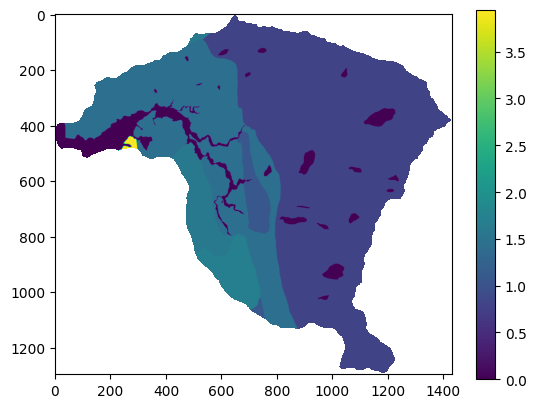

In [16]:
ag=(geologia == 2).sum()
bg=(geologia == 4).sum()
cg=(geologia == 6).sum()
dg=(geologia == 8).sum()
eg=(geologia == 9).sum()
fg=(geologia == 10).sum()
gg=(geologia == 11).sum()
hg=(geologia == 14).sum()
ig=(geologia == 15).sum()
jg=(geologia == 16).sum()

totalg=ag+bg+cg+dg+eg+fg+gg+hg+ig+jg
print("total", totalg,ag,bg,cg,dg,eg,fg,gg,hg,ig,jg)

geologiaconMenM=geologia*inventario
ag1=(geologiaconMenM == 2).sum()
bg1=(geologiaconMenM == 4).sum()
cg1=(geologiaconMenM == 6).sum()
dg1=(geologiaconMenM == 8).sum()
eg1=(geologiaconMenM == 9).sum()
fg1=(geologiaconMenM == 10).sum()
gg1=(geologiaconMenM == 11).sum()
hg1=(geologiaconMenM == 14).sum()
ig1=(geologiaconMenM == 15).sum()
jg1=(geologiaconMenM == 16).sum()

totalg1=ag1+bg1+cg1+dg1+eg1+fg1+gg1+hg1+ig1+jg1
print("total1", totalg1,ag1,bg1,cg1,dg1,eg1,fg1,gg1,hg1,ig1,jg1)

w_a=(ag1/total1)/(ag/total)
w_b=(bg1/total1)/(bg/total)
w_c=(cg1/total1)/(cg/total)
w_d=(dg1/total1)/(dg/total)
w_e=(eg1/total1)/(eg/total)
w_f=(fg1/total1)/(fg/total)
w_g=(gg1/total1)/(gg/total)
w_h=(hg1/total1)/(hg/total)
w_i=(ig1/total1)/(ig/total)
w_j=(jg1/total1)/(jg/total)
print("w:", w_a,w_b,w_c,w_d,w_e,w_f,w_g,w_h,w_i,w_j)

geologia_c=np.where ( geologia==2,w_a,geologia )
geologia_c=np.where ( geologia_c==4,w_b,geologia_c )
geologia_c=np.where ( geologia_c==6,w_c,geologia_c )
geologia_c=np.where ( geologia_c==8,w_d,geologia_c )
geologia_c=np.where ( geologia_c==9,w_e,geologia_c )
geologia_c=np.where ( geologia_c==10,w_f,geologia_c  )
geologia_c=np.where ( geologia_c==11,w_g,geologia_c  )
geologia_c=np.where ( geologia_c==14,w_h,geologia_c  )
geologia_c=np.where ( geologia_c==15,w_i,geologia_c  )
geologia_c=np.where ( geologia_c==16,w_j,geologia_c  )

plt.imshow(geologia_c)
plt.colorbar()
print(np.unique(geologia_c));

Con los mapas de cada variable reclasificados de acuerdo con el valor de *Frequency ratio* se procede entonces a sumar todas las variables y obtener el mapa de susceptibilidad:

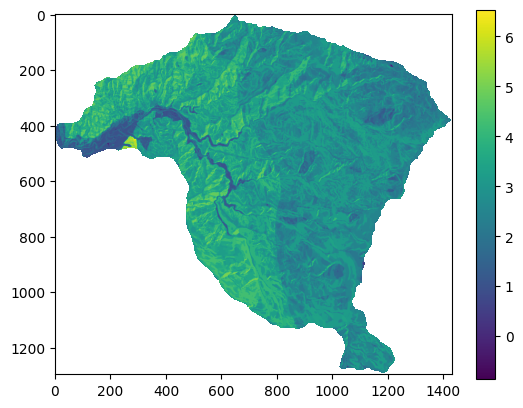

In [17]:
IS=pendiente_c+aspecto_c+geologia_c
plt.imshow(IS);
plt.colorbar();

### *Statistical index model*
El valor del peso para cada clase en el m√©todo *Statistical index model* es definido como el logaritmo natural de la densidad de movimientos en masa en una clase ($\rho_{clase}$) dividido la densidad de deslizamientos en toda la zona de estudio ($\rho_{total}$), de acuerdo con la siguiente ecuaci√≥n:

$w_{ij}^n = \ln(\frac{\rho_{clase}}{\rho_{total}}) = \ln(\frac{\frac{N_{ij}}{S_{ij}}}{\frac{N}{S}}) $

Donde $w_{ij}^n$ es el peso de la celda $n$ que pertenece a la clase $i$ de la variable $j$. $\rho_{clase}$ es la densidad de deslizamientos de la clase $i$ del par√°metro $j$, calculado a  partir de $N_{ij}$ como el n√∫mero de pixeles con MenM en una cierta clase $i$ del parametro $j$, $S_{ij}$ como el n√∫mero de pixeles de la clase $i$ del parametro $j$. N es el total de celdas que corresponden a deslizamientos en todo el mapa y S es el total de celdas del √°rea de estudio.

Finalmente la susceptibilidad a movimientos en masa de cada celda es igual a:

$S^n = \sum w = w_{pendiente} + w_{geologia} + w_{coberturas} + ...w_{n} $

#### Python

Para el m√©todo de *Statistical index* se debe calcular la densidad de movimientos en masa, tanto para las clases de cada variable, como para el √°rea total.

La densidad total es igual a:

In [ ]:
dt=total1/total
print(dt)

0.0017810045965309987


La densidad para las 5 clases de pendiente se estiman de la siguiente manera:

In [ ]:
w_a=np.log((ap1/ap)/dt)
w_b=np.log((bp1/bp)/dt)
w_c=np.log((cp1/cp)/dt)
w_d=np.log((dp1/dp)/dt)
w_e=np.log((ep1/ep)/dt)
print(w_a,w_b,w_c,w_d,w_e)

-1.9975946273658713 -0.8272443218321374 -0.19154372854191365 0.0672680287170693 0.4533616958660388


Con estos valores del *statistical index* se reclasifica el mapa de pendientes:

[-1.9975946  -0.82724434 -0.19154373  0.06726803  0.4533617          nan]


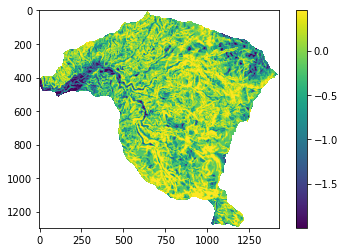

In [ ]:
pendiente_c=np.where ( (np.logical_and (pendiente>=0, pendiente<10 )),w_a,pendiente )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),w_b,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=20, pendiente_c<30 )),w_c,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=30, pendiente_c<35 )),w_d,pendiente_c )
pendiente_c=np.where ( pendiente_c>=35,w_e,pendiente_c )

plt.imshow(pendiente_c)
plt.colorbar()
print(np.unique(pendiente_c));

Realizamos el mismo procedimiento para la variable *aspecto*:

w: 0.006933187278979516 0.5611974088841332 -0.1519361180824098 -0.18464209803578424
[-1.         -0.18464209 -0.15193611  0.00693319  0.5611974          nan]


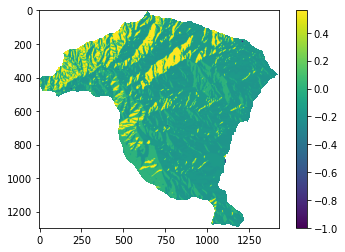

In [ ]:
w_a=np.log((aa1/aa)/dt)
w_b=np.log((ba1/ba)/dt)
w_c=np.log((ca1/ca)/dt)
w_d=np.log((da1/da)/dt)
print("w:", w_a,w_b,w_c,w_d)

aspecto_c=np.where ( (np.logical_and (aspecto>=0, aspecto<90 )),w_a,aspecto )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=90, aspecto_c<180 )),w_b,aspecto_c )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=180, aspecto_c<270 )),w_c,aspecto_c )
aspecto_c=np.where ( aspecto_c>=270,w_d,aspecto_c )

plt.imshow(aspecto_c)
plt.colorbar()
print(np.unique(aspecto_c));

Para la variable geolog√≠a se debe tener en cuenta que existen algunas clases que no presentan celdas con MenM, por lo tanto generan un error al calcular el logaritmo. Para superar esto se le asigna un valor de 1 a dichas clases.

w: 0.36987982682432763 1.200678978884011 -1.695592501139342 0.5311140506574584 -4.205723000249289 0.07473838228040365 0.4625264091580406 -0.22131946592927398 1.3725861331962508 -3.499424769466566
[-4.205723   -3.49942477 -1.6955925  -0.22131947  0.07473838  0.36987983
  0.46252641  0.53111405  1.20067898  1.37258613         nan]


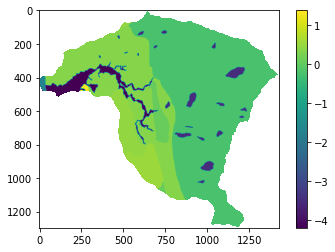

In [ ]:
bg1=cg1=eg1=jg1=1   #clases que obtuvieron 0 celdas con movimientos en masa

w_a=np.log((ag1/ag)/dt)
w_b=np.log((bg1/bg)/dt)
w_c=np.log((cg1/cg)/dt)
w_d=np.log((dg1/dg)/dt)
w_e=np.log((eg1/eg)/dt)
w_f=np.log((fg1/fg)/dt)
w_g=np.log((gg1/gg)/dt)
w_h=np.log((hg1/hg)/dt)
w_i=np.log((ig1/ig)/dt)
w_j=np.log((jg1/jg)/dt)
print("w:", w_a,w_b,w_c,w_d,w_e,w_f,w_g,w_h,w_i,w_j)

geologia_c=np.where ( geologia==2,w_a,geologia )
geologia_c=np.where ( geologia_c==4,w_b,geologia_c )
geologia_c=np.where ( geologia_c==6,w_c,geologia_c )
geologia_c=np.where ( geologia_c==8,w_d,geologia_c )
geologia_c=np.where ( geologia_c==9,w_e,geologia_c )
geologia_c=np.where ( geologia_c==10,w_f,geologia_c  )
geologia_c=np.where ( geologia_c==11,w_g,geologia_c  )
geologia_c=np.where ( geologia_c==14,w_h,geologia_c  )
geologia_c=np.where ( geologia_c==15,w_i,geologia_c  )
geologia_c=np.where ( geologia_c==16,w_j,geologia_c  )

plt.imshow(geologia_c)
plt.colorbar()
print(np.unique(geologia_c));

Con los mapas de cada variable reclasificados de acuerdo con el valor de *Statistical index* se procede entonces a sumar todas las variables y obtener el mapa de susceptibilidad:

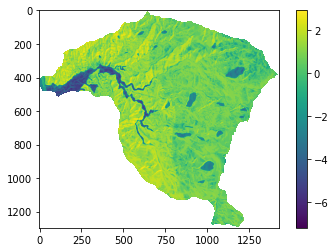

In [ ]:
IS=pendiente_c+aspecto_c+geologia_c
plt.imshow(IS);
plt.colorbar();

### Peso de la evidencia (WoE)
El Peso de la Evidencia, basado en la teor√≠a de la probabilidad Bayesiana, analiza la relaci√≥n entre las √°reas afectadas 
por los movimientos en masa y la distribuci√≥n espacial de los factores condicionantes del terreno. Este m√©todo arroja 
los pesos de las clases que conforman las variables condicionantes, indicando la presencia e influencia de la clase como par√°metro 
en la ocurrencia del movimiento en masa. Los pesos positivos (W+)  indican la presencia de la clase como par√°metro que 
favorece los movimientos en masa y su magnitud indica su correlaci√≥n. El peso negativo (W-) indica la ausencia de la clase en la ocurrencia de 
movimiento en masa. 

D√≥nde $N_{pix1}$ es el n√∫mero de pixeles con movimientos en masa ($S$) en la clase $B_i$, $N_{pix2}$ n√∫mero de pixeles con movimientos 
en masa que no est√°n presentes en la misma clase $\hat{B}_i$, $N_{pix3}$ es el n√∫mero de pixeles en la clase que no hay movimientos 
en masa $\hat{S}$ y $N_{pix4}$ es el n√∫mero de pixeles en la clase donde no hay movimientos en masa $\hat{S}$ y que no est√° presente en 
la clase  $\hat{B}_i$.

:::{figure-md} woe
<img src="https://i.pinimg.com/564x/70/a4/d5/70a4d5ecbab6d6bf9bdb0f914c91dba8.jpg" alt="woe" width="600px">

M√©todo de Peso de la Evidencia.
:::

$C = W^+ - W^-$

Y el contraste C refleja el espacio de asociaci√≥n respecto a la clase en la predicci√≥n del movimiento en masa, la cual 
es cero cuando la clase no afecta, es positivo cuando existe una correlaci√≥n directa y negativo cuando existe una correlaci√≥n inversa con la distribuci√≥n de movimientos en masa.

#### Python

Para calcular el $W^+$ (wp), $W^-$ (wn), y $C$ de cada clase se utilizan las siguientes ecuaciones del m√©todo WoE: $N_{pix1}$=a1, son las celdas que pertenecen a la clase a y tienen MenM. $N_{pix2}$=total1-a1, son las celdas que no pertenecen a la clase a y que tienen MenM, $N_{pix3}$=a-a1, son las celdas que pertenecen a la clase a pero que no tienen MenM. y $N_{pix4}$=(b+c+d+e)-(b1+c1+d1+e1), son las celdas que no pertenecen a la clase a y que no tienen MenM.

In [18]:
x1=ap1
x2=total1-ap1
x3=ap-ap1
x4=(bp+cp+dp+ep)-(bp1+cp1+dp1+ep1)

Con los valores de x1, x2, x3, x4 se calculan el $W^+$ (wp), el $W^-$ (Wn) y el Contraste de la siguiente forma:

In [19]:
wp_a=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_a=np.log((x2/(x1+x2))/(x4/(x3+x4)))
c=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))
print(wp_a, wn_a, c)

-1.9978126337233664 0.05293079554963469 -2.0507434292730014


Con el valor del contraste para la clase $a$ del mapa de pendiente, se genera un mapa de pendiente reclasificado donde todas las celdas que pertenezcan a la clase a ahora tengan el valor del contraste de $a$.

In [20]:
pendiente_c=np.where ( (np.logical_and (pendiente>=0, pendiente<10 )),c,pendiente );

Ahora se repite el mismo procedimiento para cada una de las clases en las cuales se clasific√≥ el mapa de pendientes.

In [21]:
#Clase b
x1=bp1
x2=total1-bp1
x3=bp-bp1
x4=(ap+cp+dp+ep)-(ap1+cp1+dp1+ep1)

wp_b=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_b=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),cont,pendiente_c )

#Clase c
x1=cp1
x2=total1-cp1
x3=cp-cp1
x4=(ap+bp+dp+ep)-(ap1+bp1+dp1+ep1)

wp_c=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_c=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),cont,pendiente_c )

#Clase d
x1=dp1
x2=total1-dp1
x3=dp-dp1
x4=(ap+bp+cp+ep)-(ap1+bp1+cp1+ep1)

wp_d=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_d=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

pendiente_c=np.where ( (np.logical_and (pendiente_c>=20, pendiente_c<30 )),cont,pendiente_c )

#Clase e
x1=ep1
x2=total1-ep1
x3=ep-ep1
x4=(ap+bp+cp+dp)-(ap1+bp1+cp1+dp1)

wp_e=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_e=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

pendiente_c=np.where (pendiente_c>=30,cont,pendiente_c)

Se procede a imprimir cada uno de los $W^+$ y $W^-$ para detectar valores infinitos que se obtienen de logaritmos de 0, es decir que provienen de clases donde algunos de los numeradores (x1, x2, x3, o x4) es 0.

In [22]:
print(wp_a, wn_a, wp_b, wn_b, wp_c, wn_c, wp_d, wn_d, wp_e, wn_e)

-1.9978126337233664 0.05293079554963469 -0.8269249184231674 0.09637540215921472 -0.190531748869874 0.0740267315295358 0.06871512729071115 -0.015040700202127994 0.45570855845755603 -0.2969812410286435


A continuaci√≥n se presenta el mapa de pendiente reclasificado por el Contraste (C)

[-2.0507433  -0.9233003   0.08375583  0.7526898          nan]


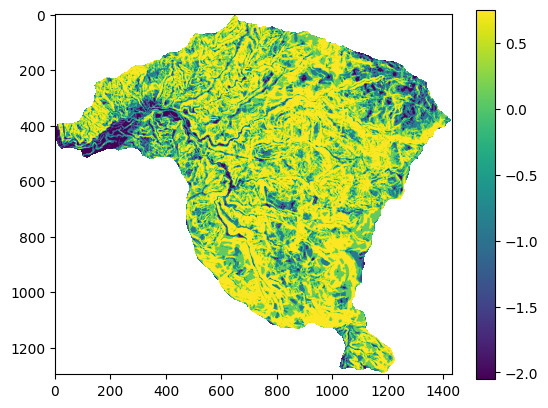

In [23]:
plt.imshow(pendiente_c)
plt.colorbar()
print(np.unique(pendiente_c));

Este mismo procedimiento se realiza para la variable *aspecto*.

In [24]:
#Clase a
x1=aa1
x2=total1-aa1
x3=aa-aa1
x4=(ba+ca+da)-(ba1+ca1+da1)

wp_a=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_a=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

aspecto_c=np.where ((np.logical_and (aspecto>=0, aspecto<90 )),cont,aspecto )

#Clase b
x1=ba1
x2=total1-ba1
x3=ba-ba1
x4=(aa+ca+da)-(aa1+ca1+da1)

wp_b=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_b=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

aspecto_c=np.where ((np.logical_and (aspecto_c>=90, aspecto_c<180 )),cont,aspecto_c )

#Clase c
x1=ca1
x2=total1-ca1
x3=ca-ca1
x4=(aa+ba+da)-(aa1+ba1+da1)

wp_c=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_c=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

aspecto_c=np.where ((np.logical_and (aspecto_c>=180, aspecto_c<270 )),cont,aspecto_c )

#Clase d
x1=da1
x2=total1-da1
x3=da-da1
x4=(aa+ba+ca)-(aa1+ba1+ca1)

wp_d=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_d=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

aspecto_c=np.where (aspecto_c>=270,cont,aspecto_c )

In [25]:
print(wp_a, wn_a, wp_b, wn_b, wp_c, wn_c, wp_d, wn_d)

0.006945600406864839 -0.0013894983310093806 0.5625413905302987 -0.13237052720363568 -0.15218757915959064 0.06932826692215219 -0.18494286273071125 0.08914131784141605


A continuaci√≥n se presenta el mapa de aspecto reclasificado por el Contraste (C)

[-1.         -0.27408418 -0.22151585  0.0083351   0.6949119          nan]


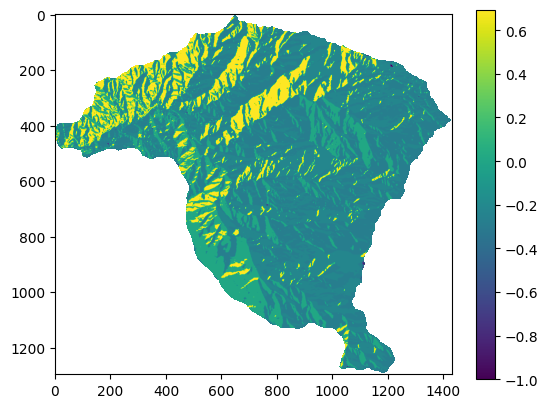

In [26]:
plt.imshow(aspecto_c)
plt.colorbar()
print(np.unique(aspecto_c));

En el m√©todo *Peso de la evidencia* se debe tener en cuenta que las clases que no presentan movimientos en masa generan un matem√°tico, ya que no se puede estimar el logaritmo natural de cero. Por lo tanto, se debe proceder a esas clases donde se obtuvo cero celdas asignarles un valor de 1, de tal forma que se pueda ejecutar el c√°lculo. 


In [27]:
bg1=cg1=eg1=jg1=1   #clases que obtuvieron 0 celdas con movimientos en masa

#Clase a
x1=ag1
x2=total1-ag1
x3=ag-ag1
x4=(bg+cg+dg+eg+fg+gg+hg+ig+jg)-(bg1+cg1+dg1+eg1+fg1+gg1+hg1+ig1+jg1)

wp_a=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_a=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where(geologia==2,cont,geologia)

#Clase b
x1=bg1
x2=total1-bg1
x3=bg-bg1
x4=(ag+cg+dg+eg+fg+gg+hg+ig+jg)-(ag1+cg1+dg1+eg1+fg1+gg1+hg1+ig1+jg1)

wp_b=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_b=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==4,cont,geologia_c)

#Clase c
x1=cg1
x2=total1-cg1
x3=cg-cg1
x4=(ag+bg+dg+eg+fg+gg+hg+ig+jg)-(ag1+bg1+dg1+eg1+fg1+gg1+hg1+ig1+jg1)

wp_c=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_c=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==6,cont,geologia_c)

#Clase d
x1=dg1
x2=total1-dg1
x3=dg-dg1
x4=(ag+bg+cg+eg+fg+gg+hg+ig+jg)-(ag1+bg1+cg1+eg1+fg1+gg1+hg1+ig1+jg1)

wp_d=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_d=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==8,cont,geologia_c)

#Clase e
x1=eg1
x2=total1-eg1
x3=eg-eg1
x4=(ag+bg+cg+dg+fg+gg+hg+ig+jg)-(ag1+bg1+cg1+dg1+fg1+gg1+hg1+ig1+jg1)

wp_e=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_e=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==9,cont,geologia_c)

#Clase f
x1=fg1
x2=total1-fg1
x3=fg-fg1
x4=(ag+bg+cg+dg+eg+gg+hg+ig+jg)-(ag1+bg1+cg1+dg1+eg1+gg1+hg1+ig1+jg1)

wp_f=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_f=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==10,cont,geologia_c)

#Clase g
x1=gg1
x2=total1-gg1
x3=gg-gg1
x4=(ag+bg+cg+dg+fg+eg+hg+ig+jg)-(ag1+bg1+cg1+dg1+fg1+eg1+hg1+ig1+jg1)

wp_g=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_g=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==11,cont,geologia_c)

#Clase h
x1=hg1
x2=total1-hg1
x3=hg-hg1
x4=(ag+bg+cg+dg+fg+gg+eg+ig+jg)-(ag1+bg1+cg1+dg1+fg1+gg1+eg1+ig1+jg1)

wp_h=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_h=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==14,cont,geologia_c)

#Clase i
x1=ig1
x2=total1-ig1
x3=ig-ig1
x4=(ag+bg+cg+dg+fg+gg+hg+eg+jg)-(ag1+bg1+cg1+dg1+fg1+gg1+hg1+eg1+jg1)

wp_i=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_i=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==15,cont,geologia_c)

#Clase j
x1=jg1
x2=total1-jg1
x3=jg-jg1
x4=(ag+bg+cg+dg+fg+gg+hg+eg+ig)-(ag1+bg1+cg1+dg1+fg1+gg1+hg1+eg1+ig1)

wp_j=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_j=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==16,cont,geologia_c)

In [28]:
print(wp_a, wn_a, wp_b, wn_b, wp_c, wn_c, wp_d, wn_d, wp_e, wn_e, wp_f, wn_f, wp_g, wn_g, wp_h, wn_h, wp_i, wn_i, wp_j, wn_j)

0.3719972196859115 -0.1727805096556783 1.2061496660464985 -0.0004326749733077856 -1.6957296987011459 0.002752779757529654 0.5336837785798685 -0.026280284312496238 -4.206160493471516 0.041683506509891124 0.07619539243600662 -0.0019984389181064706 0.4648947478986488 -0.02879076462367898 -0.2203550895609917 0.22972367754746886 1.3791739176961686 -0.006034509849750083 -3.4998350037515005 0.02003254146609238


Para este caso de la variable *geologia* se obtienen valores de 0 para las clases b, c, e y j. Por lo tanto se debe asignar valores de 1 y volver a correr el c√≥digo.

[-4.247844   -3.51986755 -1.69848248 -0.45007877  0.07819383  0.49368551
  0.54477773  0.55996406  1.20658234  1.38520843         nan]


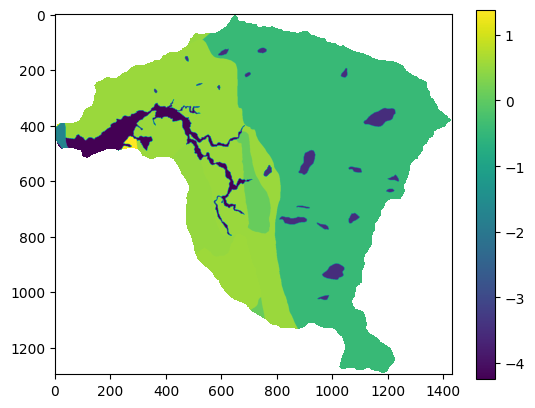

In [29]:
plt.imshow(geologia_c)
plt.colorbar()
print(np.unique(geologia_c));

Finalmente se calcula el Indice de Susceptibildiad (IS), el cual corresponde a la suma de los mapas reclasificados con el valor del Contraste, de la siguiente forma.

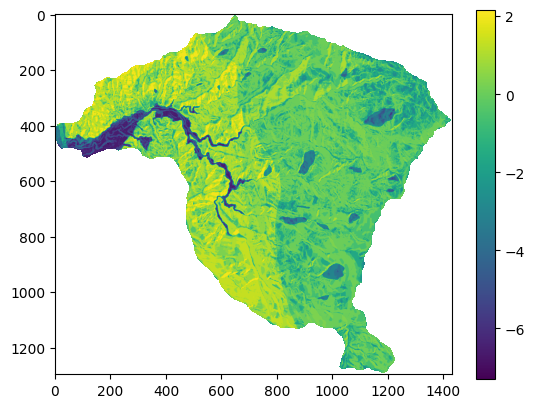

In [30]:
IS=pendiente_c+aspecto_c+geologia_c
plt.imshow(IS);
plt.colorbar();

### *Evidential Belief Funtion* (EBF)
El modelo EBF (Dempster - Shafer) consiste en el grado de *Belief* (Bel), *Disbelief* (Dis), *Uncertainty* (Unc) y *Plausibility* (Pls), con valores entre 0 y 1. Bels y Pls representan el l√≠mite de probabilidad Bayesiana inferior y superior. Mientras que, Pls es mayor o igual que Bel, y Unc es la diferencia entre ellos, indicando la incertidumbre del resultado.

$Wc_{ij}L=\frac{N(c \cap L)/N(c)}{N(L)-N(c \cap L)/N(S)-N(c)}$

$Belc_{ij}=\frac{Wc_{ij}L}{\sum{Wc_{ij}L}}$
						
$Wc_{ij} \bar L=\frac{N(c)-N(c \cap L)/N(c)}{N(S)-N(L)-N(c)-N(c \cap L)/N(S)-N(c)}$

$Disc_{ij}=\frac{Wc_{ij} \bar L}{\sum{Wc_{ij} \bar L}}$
						
$Uncc_{ij}=1-Belc_{ij} - Disc_{ij}$

:::{figure-md} ebf
<img src="https://www.researchgate.net/profile/Hossein-Nazmfar-2/publication/234059633/figure/fig5/AS:637397922508801@1528978915684/Schematic-relationships-of-evidential-belief-functions-Althuwaynee-et-al-2012.png" alt="ebf" width="600px">

M√©todo *Evidential Belief Funtion*.
:::

:::{figure-md} ebf1
<img src="https://i.pinimg.com/564x/4c/90/c3/4c90c30f26e6385e74bb00899a4f7110.jpg" alt="ebf1" width="400px">

Ejemplo del c√°lculo de *Evidential Belief Funtion*.
:::

#### *Python*

Para calcular el *Belief* de las 5 clases de la variable *pendiente* se utiliza:

In [31]:
a=(ap1/ap)/((total1-ap1)/(total-ap))
b=(bp1/bp)/((total1-bp1)/(total-bp))
c=(cp1/cp)/((total1-cp1)/(total-cp))
d=(dp1/dp)/((total1-dp1)/(total-dp))
e=(ep1/ep)/((total1-ep1)/(total-ep))

b_a=a/(a+b+c+d+e)
b_b=b/(a+b+c+d+e)
b_c=c/(a+b+c+d+e)
b_d=d/(a+b+c+d+e)
b_e=e/(a+b+c+d+e)

print("Belief:", b_a, b_b, b_c, b_d, b_e)

Belief: 0.028625875395254366 0.08834945227321032 0.1705973298301404 0.24153682967696555 0.47089051282442923


El *Disbelief* para cada una de las clases de la variable *pendiente* se calcula de la siguiente forma:

In [32]:
a=((ap-ap1)/ap)/((total-total1-ap-ap1)/(total-ap))
b=((bp-bp1)/bp)/((total-total1-bp-bp1)/(total-bp))
c=((cp-cp1)/cp)/((total-total1-cp-cp1)/(total-cp))
d=((dp-dp1)/dp)/((total-total1-dp-dp1)/(total-dp))
e=((ep-ep1)/ep)/((total-total1-ep-ep1)/(total-ep))

d_a=a/(a+b+c+d+e)
d_b=b/(a+b+c+d+e)
d_c=c/(a+b+c+d+e)
d_d=d/(a+b+c+d+e)
d_e=e/(a+b+c+d+e)

print("Disbelief:", d_a, d_b, d_c, d_d, d_e)

Disbelief: 0.20007122276845485 0.20003037043373678 0.20008822829335968 0.19986779103655192 0.19994238746789678


Finalmente *Uncertainty* se obtiene de:

In [33]:
U_a=1-b_a-d_a
U_b=1-b_b-d_b
U_c=1-b_c-d_c
U_d=1-b_d-d_d
U_e=1-b_e-d_e

print("Uncertainty:", U_a, U_b, U_c, U_d, U_e)

Uncertainty: 0.7713029018362907 0.7116201772930528 0.6293144418764999 0.5585953792864825 0.32916709970767405


En este caso se utilizar√° el *Belief* para calcular el mapa de susceptibilidad, por lo tantos se reclasifica la clase con dicho valor:

[0.02862588 0.08834945 0.17059733 0.24153683 0.47089052        nan]


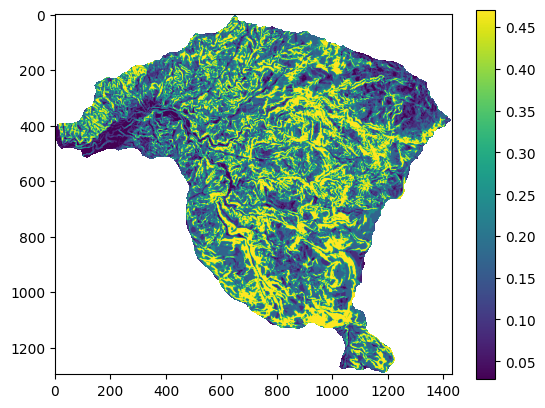

In [34]:
pendiente_c=np.where ( (np.logical_and (pendiente>=0, pendiente<10 )),b_a,pendiente )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),b_b,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=20, pendiente_c<30 )),b_c,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=30, pendiente_c<35 )),b_d,pendiente_c )
pendiente_c=np.where ( pendiente_c>=35,b_e,pendiente_c )

plt.imshow(pendiente_c)
plt.colorbar()
print(np.unique(pendiente_c));

Se realiza el mismo procedimiento para la variable *aspecto*:

Belief: 0.22057061602011757 0.4375534606380272 0.175417504448167 0.1664584188936883
Disbelief: 0.24991245472690599 0.2496034442619465 0.2502212194919437 0.2502628815192039
Uncertainty: 0.5295169292529764 0.3128430951000264 0.5743612760598893 0.5832786995871078
[-1.          0.16645841  0.1754175   0.22057061  0.43755347         nan]


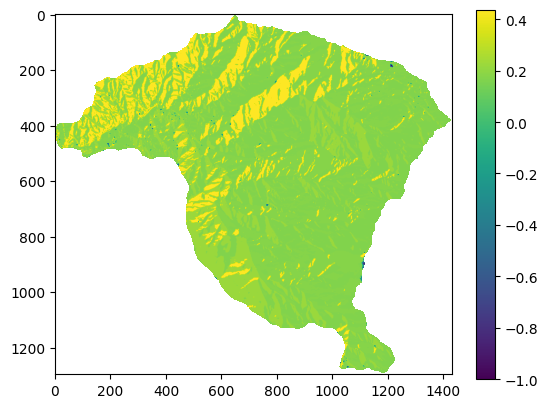

In [35]:
a=(aa1/aa)/((total1-aa1)/(total-aa))
b=(ba1/ba)/((total1-ba1)/(total-ba))
c=(ca1/ca)/((total1-ca1)/(total-ca))
d=(da1/da)/((total1-da1)/(total-da))

b_a=a/(a+b+c+d)
b_b=b/(a+b+c+d)
b_c=c/(a+b+c+d)
b_d=d/(a+b+c+d)

print("Belief:", b_a, b_b, b_c, b_d)

a=((aa-aa1)/aa)/((total-total1-aa-aa1)/(total-aa))
b=((ba-ba1)/ba)/((total-total1-ba-ba1)/(total-ba))
c=((ca-ca1)/ca)/((total-total1-ca-ca1)/(total-ca))
d=((da-da1)/da)/((total-total1-da-da1)/(total-da))

d_a=a/(a+b+c+d)
d_b=b/(a+b+c+d)
d_c=c/(a+b+c+d)
d_d=d/(a+b+c+d)

print("Disbelief:", d_a, d_b, d_c, d_d)

U_a=1-b_a-d_a
U_b=1-b_b-d_b
U_c=1-b_c-d_c
U_d=1-b_d-d_d

print("Uncertainty:", U_a, U_b, U_c, U_d)

aspecto_c=np.where ( (np.logical_and (aspecto>=0, aspecto<90 )),b_a,aspecto )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=90, aspecto_c<180 )),b_b,aspecto_c )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=180, aspecto_c<270 )),b_c,aspecto_c )
aspecto_c=np.where ( aspecto_c>=270,b_d,aspecto_c )

plt.imshow(aspecto_c)
plt.colorbar()
print(np.unique(aspecto_c));

Para la variable *geologia* se desarrolla de la siguiente forma:

Belief: 0.1199707236495513 0.23182412864291702 0.012762711682540034 0.12178004327296854 0.0009975405497327063 0.07530914038478176 0.11399277135102051 0.044446666180287905 0.27685062024542095 0.002065654040779134
Disbelief: 0.10008364483089074 0.09959527456876677 0.100155931196134 0.099902193721023 0.10019311443310329 0.10000502102163039 0.09992672976273735 0.10046596811513288 0.09948572292492794 0.10018639942565356
Uncertainty: 0.779945631519558 0.6685805967883163 0.887081357121326 0.7783177630060084 0.898809345017164 0.8246858385935878 0.7860804988862422 0.8550873657045792 0.6236636568296511 0.8977479465335673
[0.00099754 0.00206565 0.01276271 0.04444667 0.07530914 0.11399277
 0.11997072 0.12178004 0.23182413 0.27685062        nan]


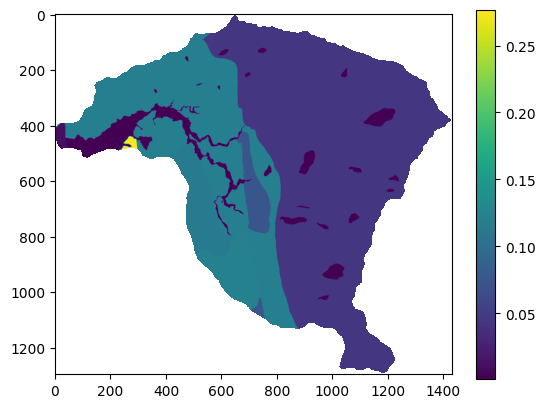

In [36]:
a=(ag1/ag)/((total1-ag1)/(total-ag))
b=(bg1/bg)/((total1-bg1)/(total-bg))
c=(cg1/cg)/((total1-cg1)/(total-cg))
d=(dg1/dg)/((total1-dg1)/(total-dg))
e=(eg1/eg)/((total1-eg1)/(total-eg))
f=(fg1/fg)/((total1-fg1)/(total-fg))
g=(gg1/gg)/((total1-gg1)/(total-gg))
h=(hg1/hg)/((total1-hg1)/(total-hg))
i=(ig1/ig)/((total1-ig1)/(total-ig))
j=(jg1/jg)/((total1-jg1)/(total-jg))


b_a=a/(a+b+c+d+e+f+g+h+i+j)
b_b=b/(a+b+c+d+e+f+g+h+i+j)
b_c=c/(a+b+c+d+e+f+g+h+i+j)
b_d=d/(a+b+c+d+e+f+g+h+i+j)
b_e=e/(a+b+c+d+e+f+g+h+i+j)
b_f=f/(a+b+c+d+e+f+g+h+i+j)
b_g=g/(a+b+c+d+e+f+g+h+i+j)
b_h=h/(a+b+c+d+e+f+g+h+i+j)
b_i=i/(a+b+c+d+e+f+g+h+i+j)
b_j=j/(a+b+c+d+e+f+g+h+i+j)


print("Belief:", b_a, b_b, b_c, b_d, b_e, b_f, b_g, b_h, b_i, b_j)

a=((ag-ag1)/ag)/((total-total1-ag-ag1)/(total-ag))
b=((bg-bg1)/bg)/((total-total1-bg-bg1)/(total-bg))
c=((cg-cg1)/cg)/((total-total1-cg-cg1)/(total-cg))
d=((dg-dg1)/dg)/((total-total1-dg-dg1)/(total-dg))
e=((eg-eg1)/eg)/((total-total1-eg-eg1)/(total-eg))
f=((fg-fg1)/fg)/((total-total1-fg-fg1)/(total-fg))
g=((gg-gg1)/gg)/((total-total1-gg-gg1)/(total-gg))
h=((hg-hg1)/hg)/((total-total1-hg-hg1)/(total-hg))
i=((ig-ig1)/ig)/((total-total1-ig-ig1)/(total-ig))
j=((jg-jg1)/jg)/((total-total1-jg-jg1)/(total-jg))


d_a=a/(a+b+c+d+e+f+g+h+i+j)
d_b=b/(a+b+c+d+e+f+g+h+i+j)
d_c=c/(a+b+c+d+e+f+g+h+i+j)
d_d=d/(a+b+c+d+e+f+g+h+i+j)
d_e=e/(a+b+c+d+e+f+g+h+i+j)
d_f=f/(a+b+c+d+e+f+g+h+i+j)
d_g=g/(a+b+c+d+e+f+g+h+i+j)
d_h=h/(a+b+c+d+e+f+g+h+i+j)
d_i=i/(a+b+c+d+e+f+g+h+i+j)
d_j=j/(a+b+c+d+e+f+g+h+i+j)

print("Disbelief:", d_a, d_b, d_c, d_d, d_e, d_f, d_g, d_h, d_i, d_j)

U_a=1-b_a-d_a
U_b=1-b_b-d_b
U_c=1-b_c-d_c
U_d=1-b_d-d_d
U_e=1-b_e-d_e
U_f=1-b_f-d_f
U_g=1-b_g-d_g
U_h=1-b_h-d_h
U_i=1-b_i-d_i
U_j=1-b_j-d_j

print("Uncertainty:", U_a, U_b, U_c, U_d, U_e, U_f, U_g, U_h, U_i, U_j)

geologia_c=np.where ( geologia==2,b_a,geologia )
geologia_c=np.where ( geologia_c==4,b_b,geologia_c )
geologia_c=np.where ( geologia_c==6,b_c,geologia_c )
geologia_c=np.where ( geologia_c==8,b_d,geologia_c )
geologia_c=np.where ( geologia_c==9,b_e,geologia_c )
geologia_c=np.where ( geologia_c==10,b_f,geologia_c  )
geologia_c=np.where ( geologia_c==11,b_g,geologia_c  )
geologia_c=np.where ( geologia_c==14,b_h,geologia_c  )
geologia_c=np.where ( geologia_c==15,b_i,geologia_c  )
geologia_c=np.where ( geologia_c==16,b_j,geologia_c  )

plt.imshow(geologia_c)
plt.colorbar()
print(np.unique(geologia_c));

Con los mapas de cada variable reclasificados de acuerdo con el valor de *Belief* se procede entonces a sumar todas las variables y obtener el mapa de susceptibilidad:

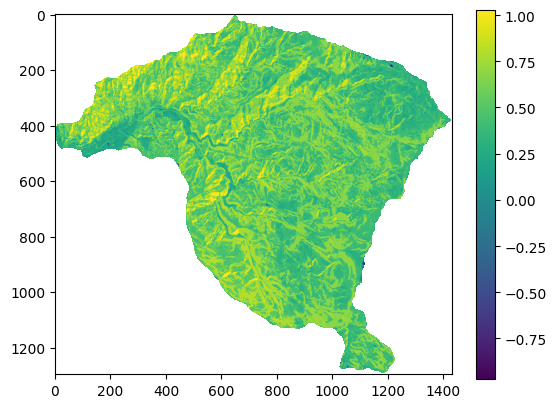

In [37]:
IS=pendiente_c+aspecto_c+geologia_c
plt.imshow(IS);
plt.colorbar();

### *Certainty Factor* (CF)
El valor de CF var√≠a entre -1 y +1. Un valor positivo significa un incremento en la certidumbre de la ocurrencia de deslizamientos, mientras que un valor negativo corresponde a una reducci√≥n en dicha certidumbre. Un valor cercano a 0 significa que la probabilidad priori es muy similar a la probabilidad condicional.

:::{figure-md} cf
<img src="https://i.pinimg.com/originals/ae/1a/55/ae1a558572dffa10393f414d91a5bf24.jpg" alt="cf" width="400px">

M√©todo de *Certainty Factor*.
:::

Donde PPa es la probabilidad condicional de la ocurrencia de un deslizamiento en la clase a. PPs es la probabilidad priori del n√∫mero total de deslizamientos en el √°rea.

#### *Python*

Los mapas finales los podemos exportar en formato *tif*, para eso en el siguiente ejemplo se utiliza el mapa de pendientes para extraer las dimensiones de la matriz (mapa) a crear de la zoan de estudio.

In [ ]:
meta=raster.profile
raster_transform = meta['transform']
raster_crs = meta['crs']

with rio.open('Desktop/IS.TIF', 'w', 
              driver='Gtiff',height=pendiente.shape[0],width=pendiente.shape[1],count=1,
              dtype='float64',nodata=-999,crs=raster_crs,transform=raster_transform) as dst:
    dst.write(IS,1);

## Multivariados
A diferencia de los m√©todos estad√≠sticos bivariados, que combinan el inventario de movimientos en masa con cada variable por separado, los m√©todos estad√≠sticos multivariados eval√∫an la relaci√≥n combinada entre la variable dependiente (la ocurrencia de movimientos en masa) y todas variables independientes (variables predictoras) en simultanea.

Entre las limitaciones que presentan los m√©todos estad√≠sticos multivariados se encuentra que los resultados implican que los movimientos en masa ocurren por la misma combinaci√≥n de factores a lo largo del √°rea de estudio. Esta generalizaci√≥n ignora el hecho que la ocurrencia de ciertos tipos de movimientos en masa est√°n controlados por ciertos factores de causa que deben ser analizados o investigados individualmente.

Inicialmente se describe el m√©todo denominado *an√°lisis condicional*, el cual es el √∫nico de los m√©todos que NO se considera una t√©cnica de *machine learning*. 

##### M√©todo de An√°lisis Condicional
El m√©todo de an√°lisis condicional, o tambi√©n denominado *matrix assessment* fue desarrollado por {cite:t}`Clerici2002`, y no requiere asunciones de aleatoriedad del fen√≥meno bajo an√°lisis. En general es utilizado por su simpleza conceptual y matem√°tica, sin embargo desde el punto de vista procedimental puede ser demandante.

Se fundamente en el uso de la unidad de an√°lisis denominada Unidad de Condiciones Unicas (UCU). El procedimiento es el siguiente: (i) elaborar el mapa de UCU a partir de las variables predictoras seleccionadas, (ii) se cruza el mapa de UCU con el inventario de movimientos en masa, (iii) se calcula para cada UCU el porcentaje de √°rea con movimientos en masa, (iv) finalmente, se clasifican de acuerdo con el porcentaje de √°rea afectada. Ese porcentaje, que corresponde a una densidad relativa, es equivalente a la probabilidad futura de la ocurrencia de movimientos en masa.

:::{figure-md} metodo ucu
<img src="https://i.pinimg.com/564x/cc/6d/00/cc6d00fc1e76c817cac53b08377c25b2.jpg" alt="metodo ucu" width="500px">

M√©todo de an√°lisis condicional. Tomado de Urquia et al., (2020).
:::

### M√©todos de *machine learning*
Como parte de los m√©todos multivariados se encuentran disponibles t√©cnicas de aprendizaje autom√°tico de m√°quinas (*machine learning*), tales como la regresi√≥n log√≠stica, la cual ha sido el m√©todo mas utilizado alrededor del mundo para evaluar la susceptibilidad por movimientos en masa; al igual que el m√©todo de an√°lisis discriminante lineal, el cual es el exigido en los estudios de amenaza en los Planes de Ordenaci√≥n y Manejo de Cuencas (POMCA) en Colombia. Pero adicionalmente, algoritmos como *support vector machine*, m√©todos ensamblados tipo *bagging* como *random forest*, tipo boosting como *XGBoost*, y t√©cnicas de *deep learning* como redes neuronales artificiales. 

:::{figure-md} ml
<img src="https://miro.medium.com/max/477/1*KFQI59Yv7m1f3fwG68KSEA.jpeg" alt="ml" width="500px">

Algoritmos utilizados en *machine learning*
:::

Los m√©todos de *machine learning* se pueden dividir en m√©todos param√©tricos y no-param√©tricos. Los **modelos param√©tricos** simplifican el aprendizaje a partir de los datos de entrenamiento, ya que utilizan una funci√≥n conocida que generalmente corresponde a una combinaci√≥n lineal de las variables predictoras. Por lo que como resultado siempre se obtiene los coeficientes de la funci√≥n predeterminada. Estos modelos adem√°s de no exigir una gran capacidad computacional, son muy estables sin presentar problemas de varianza. Sin embargo, en muchos casos el problema a modelar no se ajusta a una funci√≥n lineal, por lo que pueden presentar problemas de ajuste o sesgo. Para estos casos se recomienda el uso de **modelos no param√©tricos**, ya que no asumen ninguna forma previa de la funci√≥n objetivo, permitiendo aprender en teor√≠a a partir de los datos de entrenamiento cualquier forma de la funci√≥n. Generalmente no presentan problemas de ajuste o sesgo, pero en su defecto tienden a sobre ajustarse a los datos, generando problemas de varianza ante nuevas observaciones. En este sentido, un buen modelo se soporta en un balance entre el ajuste y la varianza, desafortunadamente mejorar en uno de estos aspectos implica generalmente reducci√≥n en el otro.

#### Modelos Param√©tricos

Una ventaja clave de de los m√©todos param√©tricos es que mantienen un alto grado de interpretabilidad, lo que permite al usuario evaluar directamente el papel de las covariables en relaci√≥n con la ocurrencia de deslizamientos. Esto contrasta con la mayor√≠a de los modelos de **machine learning**, en los que la interpretabilidad a menudo se pierde. Los m√©todos no param√©tricos tienden a sacrificar la interpretabilidad en favor de un mayor poder predictivo. Sin embargo, la interpretabilidad es un aspecto fundamental en la modelaci√≥n, ya que no se trata √∫nicamente de realizar buenas predicciones, sino tambi√©n de establecer de manera clara la relaci√≥n entre las variables predictoras y la variable dependiente.

##### An√°lisis Discriminante Lineal

El an√°lisis discriminante lineal (LDA) es una t√©cnica estad√≠stica que crea una funci√≥n capaz de clasificar los fen√≥menos, teniendo en cuenta una serie de variables discriminadoras y una probabilidad de pertenencia. LDA encuentra combinaciones lineales de variables que mejor ‚Äúdiscriminan‚Äù las clases de la variable respuesta. LDA supone que las variables predictoras son variables aleatorias continuas normalmente distribuidas y con la misma varianza.

El enfoque de Fisher para LDA es encontrar una combinaci√≥n lineal de predictores que maximice la matriz de covarianza entre grupos, relativo a la matriz de covarianza dentro del grupo (intra-grupo). La soluci√≥n a este problema de optimizaci√≥n es el vector propio correspondiente al valor propio m√°s grande. Este vector es un discriminante lineal (e.g. una variable). Resolver para la configuraci√≥n para dos grupos la funci√≥n discriminante $S^{-1}(X_1-X_2)$ donde $S^{-1}$ es la inversa de la matriz de covarianza de los datos $X_1$ y $X_2$ son las medias de cada predictor en los grupos de respuesta 1 y 2. En la pr√°ctica, una nueva muestra, $u$, se proyecta sobre la funci√≥n discriminante como $uS^{-1}(X_1-X_2)$, que devuelve una puntuaci√≥n discriminante. Luego, una nueva muestra se clasifica en el grupo 1 si la muestra est√° m√°s cerca de la media del grupo 1 que de la media del grupo 2 en la proyecci√≥n.

:::{figure-md} ml
<img src="https://i.pinimg.com/736x/d2/c5/52/d2c552375b74bf0ca9c3aee1f9d9dc07.jpg" alt="ml" width="500px">

An√°lisis discriminante
:::

###### *Python*

El procedimiento para todos los m√©todos de *machine learning* con *sklearn* son muy similares. Se importa la librer√≠a, se instancia el modelo con los [hiperpar√°metros](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) deseados, en este caso vamos a proyectar los datos sobre un nuevo eje (funci√≥n discriminante), se entrena el modelo, y se predice.

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis(n_components=1)
LDA

LinearDiscriminantAnalysis(n_components=1)

El primer paso es crear un *Dataframe* con todas las variables y el inventario. A partir de este *Dataframe* se construye un vector con la variable *y* (ocurrencia o no de movimientos en masa), que permitir√° entrenar el modelo, y otro *Dataframe* con solo las variables predictoras.

In [43]:
from pandas import DataFrame
d={'inventario':inventario_vector_MenM,'pendiente':pendiente_vector_MenM,'aspecto':aspecto_vector_MenM,'geologia':geologia_vector_MenM}
df = pd.DataFrame(d)
df.head()

inventario  pendiente     aspecto  geologia
0         0.0  10.862183  208.523560      14.0
1         0.0  12.265345  207.437332      14.0
2         0.0  12.469252  202.684647      14.0
3         0.0  13.148026  211.619766      14.0
4         0.0  14.091524  220.028976      14.0

Lo primero que se recomienda es normalizar los valores.

In [44]:
var_names2=['aspecto','pendiente']
for var in var_names2:
    df[var]=(df[var]-df[var].mean())/df[var].std()
df.head()

inventario  pendiente   aspecto  geologia
0         0.0  -1.582132 -0.052203      14.0
1         0.0  -1.460352 -0.063030      14.0
2         0.0  -1.442655 -0.110407      14.0
3         0.0  -1.383744 -0.021339      14.0
4         0.0  -1.301858  0.062487      14.0

In [45]:
X=df.drop("inventario", axis=1)
y=df['inventario']
X.head()

pendiente   aspecto  geologia
0  -1.582132 -0.052203      14.0
1  -1.460352 -0.063030      14.0
2  -1.442655 -0.110407      14.0
3  -1.383744 -0.021339      14.0
4  -1.301858  0.062487      14.0

In [46]:
model = LDA.fit(X,y)

Para obtener el mapa se realiza la predicci√≥n con el *Dataframe* que tiene todos las celdas, y luego se redimensiona este vector a la matriz que forma la cuenca, utilizando como m√°scara el mapa de pendiente. Pero para esto debemos contruir un *Dataframe* con todas las celdas pero que en este caso sin la transformaci√≥n de la variable *geologia*. Estos modelos permiten trabajar con variables categ√≥ricas sin transformaci√≥n.

In [54]:
f={'pendiente':pendiente_vector2,'aspecto':aspecto_vector2,'geologia':geologia_vector2}
x_map=pd.DataFrame(f)
x_map

pendiente  aspecto  geologia
0              0.0      0.0       0.0
1              0.0      0.0       0.0
2              0.0      0.0       0.0
3              0.0      0.0       0.0
4              0.0      0.0       0.0
...            ...      ...       ...
1854705        0.0      0.0       0.0
1854706        0.0      0.0       0.0
1854707        0.0      0.0       0.0
1854708        0.0      0.0       0.0
1854709        0.0      0.0       0.0

[1854710 rows x 3 columns]

In [56]:
IS=model.predict(x_map)

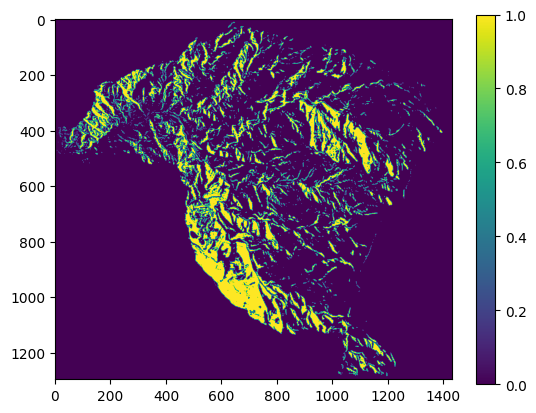

In [57]:
IS=IS.reshape(pendiente.shape)
IS=np.where(pendiente<0,np.nan,IS)
plt.imshow(IS)
plt.colorbar();


Entre los modelos param√©tricos se destacan los **Modelos Lineales Generalizados** (**GLM**, por sus siglas en ingl√©s). Los GLM comprenden una amplia clase de modelos en los que se asume que la variable de respuesta ($y$) sigue una distribuci√≥n de la familia exponencial, como la gaussiana, de Poisson, binomial o gamma. El valor esperado de la respuesta ($\mu$) se modela mediante un predictor lineal ($\eta$) a trav√©s de una funci√≥n de enlace ($g(\mu) = \eta$) que asume efectos (o pesos) aditivos de las covariables. Los GLM presentan numerosas ventajas frente a otros m√©todos estad√≠sticos, ya que pueden incorporar tanto covariables continuas como discretas, y permiten una interpretaci√≥n directa de los coeficientes del modelo.

A continuaci√≥n se presentan los GLM de mayor utilidad para evaluar la susceptibilidad por movimientos en masa:

##### Regresi√≥n log√≠stica

La regresi√≥n log√≠stica  (RL) ha sido, durante mucho tiempo, un m√©todo GLM ampliamente utilizado para modelar la susceptibilidad a movimientos en masa. La RL estima la relaci√≥n de una variable dependiente categ√≥rica (la ocurrencia de movimientos en masa) de valores binarios de 0 (no ocurrencia) y 1 (si ocurrencia), con un grupo de variables independientes, en este caso las variables condicionantes del terreno. De esta forma, la RL se utiliza para clasificar a qu√© grupo, ocurrencia=1 √≥ no-ocurrencia=0, pertenece una observaci√≥n en funci√≥n de diferentes variables predictoras. Para esto la RL estima la probabilidad de *y* de pertenecer a cada grupo transformando la combinaci√≥n lineal de las variables predictoras (*x*) mediante la funci√≥n *logit* o *sigmoid*. Lo que le permite transformar los valores arrojados por la combinaci√≥n lineal a un dominio entre 0 y 1. La funci√≥n *logit* se define como el logaritmo natural de la relaci√≥n entre la probabilidad de ocurrencia y la probabilidad de no ocurrencia, tambi√©n denominada *odds*

$P(y/x) = \frac{1}{1+e^{-z}}$
			
$\frac{p(y/x)}{1-p(y/x)} = e^{a+\sum bx}$
						
$Ln(\frac{p(y/x)}{1-p(y/x)}) = a+\sum bx$

Donde $P(y/x)$ es la probabilidad que *y* sea igual a 1 dado *X*, es decir la ocurrencia de movimientos en masa, dado la combinaci√≥n lineal de las variables independientes:

$z=\beta_o+\beta_1X_1+\beta_2X_2+\beta_3X_3+...+\beta_nX_n$

Donde $\beta_0$ es el intercepto del modelo, los valores $\beta_i$ (i=1,2, 3, n) son los coeficientes de la regresi√≥n log√≠stica, es decir, los pesos de las variables, y los valores $X_i$ (i=1, 2, 3,..., n) son las variables independientes. El resultado final es un valor entre 0 y 1, donde 0 es la probabilidad nula de ocurrencia de movimientos en masa y 1 la m√°xima probabilidad de ocurrencia. De acuerdo con esto, a pesar de que el modelo transformado es lineal en las variables, las probabilidades no son lineales.

La ventaja de la RL es que las variables predictoras no requieren tener distribuci√≥n normal y pueden ser discretas o continuas, o una combinaci√≥n de ambas. Sin embargo, para incorporar variables categ√≥ricas se deben transformar a variables binarias todas las clases, es decir una nueva variable por cada clase. El modelo en este caso elimina una clase, que pasa a ser la clase referente, y arroja un coeficiente para las demas clases. Es decir que los coeficientes de las clases se interpretan con respecto a la clase faltante. Esta eliminaci√≥n de una clase se realiza con el objeto de evitar la multicolinealidad entre variables, ya que todas las clases sumadas dan como resultado un vector constante igual a 1, es decir que se correlacionan perfectamente.

Sin embargo, la regresi√≥n log√≠stica puede ser inconsistente al aplicarse en diferentes resoluciones espaciales y unidades de mapeo, debido a la naturaleza binaria de la variable de respuesta, la cual solo indica la presencia o ausencia de uno o m√°s deslizamientos, sin diferenciar entre el n√∫mero de eventos.


:::{figure-md} rl0
<img src="https://i0.wp.com/www.jacobsoft.com.mx/wp-content/uploads/2018/10/grafica-sigmoi.png?resize=800%2C420&ssl=1" alt="rl0" width="600px">

Funci√≥n log√≠stica.
:::

A continuaci√≥n se presenta un ejemplo de la estimaci√≥n del coeficiente de la regresi√≥n log√≠stica para un problema de la ocurrencia o no de movimientos en masa dada dado una sola variable, la pendiente, clasificada en dos clases, pendientes $<20¬∞$ y pendientes $>20¬∞$. 

:::{figure-md} rl1
<img src="https://i.pinimg.com/564x/59/ce/fe/59cefecb396127fa7252a395c30eb23f.jpg" alt="rl1" width="500px">

Ejemplo 1 regresi√≥n log√≠stica.
:::

El coeficiente estimado es $-0.46$, el cual se obtiene a partir del logaritmo natural de la relaci√≥n entre los *odds* de la clase pendientes $>20¬∞$ con respecto a la ocurrencia de movimientos en masa y los *odds* de clase pendientes $<20¬∞$. Los *odds* para cada clase de pendiente corresponde a la probabilidad de ocurrencia de movimientos en masa en dicha clase sobre la probabilidad de no ocurrencia.

En el siguiente ejemplo se presentan los resultados tanto para el coeficiente de la pendiente como el intercepto, lo que permite construir la combinaci√≥n lineal y estimar la probabilidad de ocurrencia de un movimiento en masa cuando la pendiente es $>20¬∞$ o cuando es $<20¬∞$. Para estimar esta probabilidad solo se debe reemplazar en la funci√≥n *sigmoid* el valor de *x* por 1, cuando la pendiente es $>20¬∞$, o por el valor de 0 cuando la pendiente es $<20¬∞$.

:::{figure-md} rl2
<img src="https://i.pinimg.com/564x/61/e3/8f/61e38fb081e8b0638a090514b2550f6b.jpg" alt="rl2" width="500px">

Ejemplo 2 regresi√≥n log√≠stica.
:::

Como se puede observar, cuando se aplica la funci√≥n *e* al coeficiente de la pendiente se obtiene los *odds*, es decir la probabilidad de ocurrencia de movimientos en masa dado que la pendiente sea $>20¬∞$  sobre la probabilidad de ocurrencia de movimientos en masa dado que la pendiente sea $<20¬∞$. En este caso que el valor obtenido es 0.63 significa que es mas probale la ocurrencia para celdas con pendiente $<20¬∞$.

###### *Python*

A continuaci√≥n se implementar√° el m√©todo de RL para evaluar la susceptibilidad por movimientos en masa con los datos utilizados en el m√©todo anterior. En este ejemplo s√≥lo se utilizar√°n tres variables (*pendiente*, *aspecto* y *geologia*).

Existen dos librer√≠as que nos permiten resolver este modelo, *statsmodels* y *sklearn*. La primera de ellas nos ofrece un resumen con los resultados y m√©tricas de desempe√±o del modelo y utilizar la librer√≠a **Patsy** que permite el uso de f√≥rmulas.

In [58]:
import statsmodels.formula.api as sfm
lr   = sfm.logit(formula = "inventario ~ pendiente + C(geologia)", data = df).fit()
print(lr.summary())

         Current function value: 0.012661
         Iterations: 35


C:\Users\edier\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:             inventario   No. Observations:               910801
Model:                          Logit   Df Residuals:                   910790
Method:                           MLE   Df Model:                           10
Date:                Sat, 12 Apr 2025   Pseudo R-squ.:                 0.02902
Time:                        12:24:32   Log-Likelihood:                -11532.
converged:                      False   LL-Null:                       -11876.
Covariance Type:            nonrobust   LLR p-value:                1.220e-141
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -6.0824      0.042   -143.464      0.000      -6.166      -5.999
C(geologia)[T.4.0]     -9.0436    157.946     -0.057      0.954    -318.611     300.524
C(geologia)[T.6.

La librear√≠a *statsmodels* incorpora por defecto el intercepto en el modelo y en las f√≥rmulas pueden especificar el tipo de variables categ√≥ricas con una *C*. Utiliza por defecto *solver = newton-cg*. Como se menciono anteriormente las clases de las variables categ√≥ricas son transformadas en variables binarias, eliminando una. En este caso se elimin√≥ la clase 2 de *geologia*, por lo que los coeficientes de las demas clases son con respecto a dicha clase. Entre los resultados se destacan el estimador para los coeficientes (maxima verosimilitud -MLE-), el logaritmo del estimador MLE (Log-likelihood), el coeficiente de ajuste (Pseudo R-squ.). Con respecto a los coeficientes se presenta el valor de la prueba de hip√≥tesis nula que el valor del coeficiente sea igual a cero (z) como el valor del coeficiente y el error estandar (std err), y el *p-value* (P>|z|), este valor debe ser menor al 5% (0.05), lo cual significa que la probabilidad que el coeficiente tenga un valor de 0 es muy bajo.  Finalmente se presenta el rango del 95% del dominio del valor del coeficiente, si el coeficiente es estad√≠sticamente significativo, dicho rango no debe contener el valor 0.

La librer√≠a  *scikit learn* permite parametrizar el modelo de diferentes formas, sin embargo requiere separar variables dependientes y variables independientes. Asi como transformar la variable categ√≥rica y eliminar una clase. Tambi√©n es importante tener en cuenta que la funci√≥n *LogisticRegression()* por defecto utiliza como *solver = lbfgs* y *L2 regularization*, por lo que adiciona un t√©rmino extra a la funci√≥n *log-loss*. De esta forma, si se quiere obtener valores comparables a los del statsmodels se debe utilizar *LogisticRegression(penalty=None)*.

In [65]:
dummy_geologia=pd.get_dummies(X['geologia'],prefix='geo')
column_name=X.columns.values.tolist()
column_name.remove('geologia')
X1=X[column_name].join(dummy_geologia)
X1.drop('geo_2.0',axis=1,inplace=True)
X1.head()

pendiente   aspecto  geo_4.0  geo_6.0  geo_8.0  geo_9.0  geo_10.0  \
0  -1.582132 -0.052203    False    False    False    False     False   
1  -1.460352 -0.063030    False    False    False    False     False   
2  -1.442655 -0.110407    False    False    False    False     False   
3  -1.383744 -0.021339    False    False    False    False     False   
4  -1.301858  0.062487    False    False    False    False     False   

   geo_11.0  geo_14.0  geo_15.0  geo_16.0  
0     False      True     False     False  
1     False      True     False     False  
2     False      True     False     False  
3     False      True     False     False  
4     False      True     False     False

Inicialmente, se importa la funci√≥n para RL, y se construye el modelo con los hiperpar√°metros. En este caso, estamos asign√°ndole un *class_weight* = balanced para que asigne mas peso a las celdas minoritarias, en este caso las celdas donde y=1. De esta forma RL nos ayuda a resolver el problema de la base de datos original  desbalanceada. El segundo hiperpar√°metro que utilizamos es el tipo de algoritmo para resolver la RL, en este caso utilizaremos *newton-cg*. La librera "skilearn" utiliza por defecto el hiperpar√°metro *fit_intercept* con un valor de *True* que equivale a incluir el intercepto.

In [66]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(class_weight='balanced', penalty = "none", max_iter=1000, solver='newton-cg')
model

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='none',
                   solver='newton-cg')

Luego de tener el modelo construido, se le asignan los datos con la funci√≥n *fit*, en este caso, primero la matriz con las variables predictoras, y luego la variable *y*. De esta forma el modelo se entrena con los datos y se pueden obtener los resultados de los valores de los coeficientes con la funci√≥n *coef_*

In [67]:
result=model.fit(X1,y)
print(result.coef_)

C:\Users\edier\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[[ 5.0895143e-01 -4.9221581e-03 -9.4745655e+00 -1.2263961e+01
   4.5563515e-02 -1.4471029e+01 -3.7009606e-01  1.0903081e-01
  -6.0363793e-01  1.3708341e+00 -1.4364478e+01]]


C:\Users\edier\miniconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\edier\miniconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Con el modelo entrenado y guardado en la varible *result* podemos entonces obtener los valores que predice el modelo para toda la matriz con las variables predictoras. Para eso se utiliza la funci√≥n *predict*. Esta funci√≥n clasifica cada celda como inestable (1) o estable (0).

In [68]:
y_pred=result.predict(X1)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

Sin embargo, tambien se puede obtener los resultados del modelo antes de clasificarlo como (0,1). es decir la probabilidad de cada celda de ser 0 o de ser 1. Para eso se utiliza la funci√≥n *predict_proba*. La cual puede ser mas √∫til para nuestro mapa.

In [69]:
y_prob=result.predict_proba(X1)
y_prob

array([[0.761943  , 0.238057  ],
       [0.75050884, 0.24949116],
       [0.74877465, 0.25122532],
       ...,
       [0.5871985 , 0.4128015 ],
       [0.6158412 , 0.3841588 ],
       [0.6158377 , 0.3841623 ]], dtype=float32)

Como se puede observar el resultado en este caso, en lugar de ser un vector con la clasificaci√≥n de cada celda, es un matriz de dos columnas. Donde la primera columna es la probabilidad de cada celda de ser 0, es decir estable, y la segudna columna la probabilidad de ser 1, es decir inestable. Para nuestro prop√≥sito es mas √∫til obtener la probabilidad de cada celda de ser inestable. Para eso seleccionamos entonces solo la segunda columna de la matriz obtenida.

In [70]:
y_probs=result.predict_proba(X1)[:,1]
y_probs

array([0.238057  , 0.24949116, 0.25122532, ..., 0.4128015 , 0.3841588 ,
       0.3841623 ], dtype=float32)

Ya tenemos los resultados y la predicci√≥n para todas las celdas. Sin embargo esto lo tenemos para un vector que construimos la principio que solo contiene las celdas dentro de la cuenca, es decir elimin√≥ todas las celdas por fuera. Eso nos impide construir nuestra cuenca a partir de este vector.

Una forma de resolver esto se presenta a continuaci√≥n. Existen muchas formas, seguramente otras mas directas.

Para este caso construiremos entonces un nuevo *Dataframe*, pero en este caso con el vector completo, sin eliminar las celdas por fuera de la cuenca, y las celdas por fuera de la cuenca, en lugar de tener un valor de NaN les daremos un valor de 0. Las funciones de *sklearn* no corren cuando encuentra dentro de los valores NaN.

De igual forma, hay que transformar las variables categ√≥ricas a variables tipo *dummy* y en este caso debemos eliminar una nueva columna que se forma con el intercepto y que denomina *0.0*

In [75]:
pendiente_vector2=np.nan_to_num(pendiente_vector)
aspecto_vector2=np.nan_to_num(aspecto_vector)
geologia_vector2=np.nan_to_num(geologia_vector)

In [79]:
f={'pendiente':pendiente_vector2,'aspecto':aspecto_vector2,'geologia':geologia_vector2}
x_map=pd.DataFrame(f)
dummy_geologia=pd.get_dummies(x_map['geologia'],prefix='geo')
column_name=x_map.columns.values.tolist()
column_name.remove('geologia')
x_map=x_map[column_name].join(dummy_geologia)
x_map=x_map.drop('geo_2.0',axis=1)
x_map=x_map.drop('geo_0.0',axis=1)

Como se puede observar, tenemos ahora una matriz con todas las variables y con un n√∫mero mayor de celdas.

Con esta matriz podemos entonces obtener para cada celda la probabilidad que se inestable.

In [81]:
y_pred=model.predict_proba(x_map)[:,1]

Ya lo √∫nico que nos queda es reconstruir a partir de dicho vector la matriz que conforma la cuenca con los valores de susceptibilidad. Para eso utilizaremos como m√°scara el mapa de pendiente.

In [82]:
raster = rio.open('https://github.com/edieraristizabal/Libro_cartoGeotecnia/blob/master/data/miel/Pendiente.tif?raw=true')
pendiente=raster.read(1)

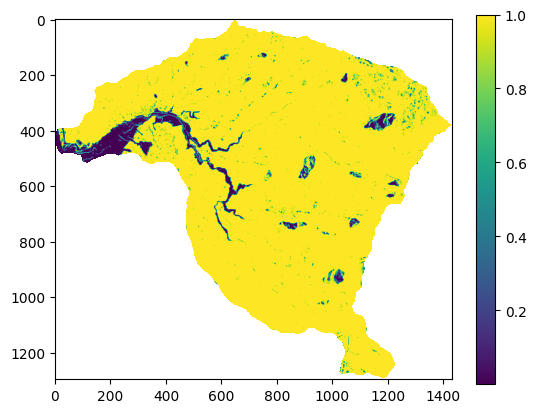

In [83]:
IS=y_pred.reshape(pendiente.shape)
IS=np.where(pendiente<0,np.nan,IS)
plt.imshow(IS)
plt.colorbar();

##### Modelo de Poisson

La regresi√≥n de Poisson es otro miembro de la familia GLM que permite modelar datos de conteo, lo cual posibilita la agregaci√≥n del n√∫mero de deslizamientos y sus probabilidades dentro de cualquier TMU. La distribuci√≥n de Poisson se utiliza debido a su adecuaci√≥n para modelar datos de conteo no negativos ($ùëå_ùëñ$=0,1,2,‚Ä¶) y su relaci√≥n con procesos que cuentan la ocurrencia de eventos en el espacio. La distribuci√≥n de Poisson describe la probabilidad de que un n√∫mero de eventos $ùëå_ùëñ$ ocurra en un intervalo de tiempo o una regi√≥n espacial dada, si esos eventos suceden con una tasa constante $ùúÜ_ùëñ$:

$$
P(Y_i = y_i) = \frac{\lambda_i^{y_i} e^{-\lambda_i}}{y_i!}, \quad y_i = 0, 1, 2, \ldots
$$

donde: $ùúÜ_ùëñ$: tasa o intensidad esperada del n√∫mero de eventos en la regi√≥n, $ùëñ$, $ùë¶_ùëñ$: n√∫mero observado de eventos en la regi√≥n $ùëñ$.

Los Modelos Lineales Generalizados (GLM) son modelos en los que las variables de respuesta siguen una distribuci√≥n distinta a la distribuci√≥n normal. El modelo lineal generalizado de Poisson se especifica de la siguiente manera:

$$
\lambda_i = \mathbb{E}[Y_i] = e^{\eta_i}
$$

donde:

$$
\eta_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip}
$$

y $ùúÇ_ùëñ$ es la parte lineal del modelo que depende de las covariables $ùë•_{ùëñj}$ y de los par√°metros $ùõΩ_ùëó$ (para $ùëó=0,1,‚Ä¶,ùëù$. En los modelos de Regresi√≥n de Poisson, las variables predictoras o explicativas pueden ser una mezcla de valores num√©ricos o categ√≥ricos.

En el modelo de Poisson, la funci√≥n de enlace que relaciona la media $ùúÜ_ùëñ$ con la parte lineal $ùúÇ_ùëñ$ es el logaritmo natural. Es decir, la funci√≥n de enlace es:

$$
\eta_i = \log(\lambda_i)
$$

De esta forma, la media de la distribuci√≥n de Poisson se relaciona exponencialmente con la combinaci√≥n lineal de las covariables:

$$
\lambda_i = e^{\beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip}}
$$

Esta forma asegura que la intensidad $ùúÜ_ùëñ$ siempre ser√° positiva, como es necesario en una distribuci√≥n de Poisson.

Los coeficientes se calculan utilizando m√©todos como la Estimaci√≥n de M√°xima Verosimilitud (MLE) o la cuasi-verosimilitud m√°xima.

La distribuci√≥n de Poisson puede ser considerada como el l√≠mite de una distribuci√≥n binomial. La distribuci√≥n binomial modela el n√∫mero de √©xitos en un n√∫mero fijo de ensayos independientes. Si el n√∫mero de ensayos es muy grande, pero la probabilidad de √©xito en cada ensayo es muy baja (es decir, si los eventos son raros), la distribuci√≥n de Poisson resulta ser una muy buena aproximaci√≥n para modelar el n√∫mero total de √©xitos. Mientras que la distribuci√≥n de Poisson se usa, entonces, para modelar situaciones en las que estamos contando eventos raros que ocurren a lo largo de un intervalo (de tiempo, espacio, etc.). Por ejemplo, la cantidad de accidentes de tr√°fico en un cruce por d√≠a, o el n√∫mero de llamadas que llegan a un centro de emergencias por minuto.

En el contexto de un modelo de Poisson, como los Modelos Lineales Generalizados de Poisson (GLM de Poisson) para an√°lisis espacial, los t√©rminos **sobredispersi√≥n** y **subdispersi√≥n** se refieren a la relaci√≥n entre la varianza y la media de los datos observados, y c√≥mo esta relaci√≥n se ajusta a las expectativas de la distribuci√≥n de Poisson. Estos conceptos son cruciales porque la distribuci√≥n de Poisson tiene una caracter√≠stica espec√≠fica: la media y la varianza son iguales. Sin embargo, en la pr√°ctica, los datos espaciales frecuentemente presentan patrones que difieren de esta suposici√≥n, lo que da lugar a la sobredispersi√≥n o la subdispersi√≥n.

En un modelo de Poisson, la media y la varianza est√°n directamente relacionadas de la siguiente manera:

Si $ùëå_ùëñ$ sigue una distribuci√≥n de Poisson con media $ùúÜ_ùëñ$:

$$
Var(ùëå_ùëñ)=ùê∏[ùëå_ùëñ]=ùúÜ_ùëñ‚Äã
$$

Es decir, la varianza y la media son iguales. Esta propiedad, sin embargo, no siempre se cumple cuando se modelan datos reales, especialmente en datos espaciales.

La sobredispersi√≥n ocurre cuando la varianza de los datos es mayor que la media. Es decir, los datos muestran m√°s variabilidad de la que el modelo de Poisson predice. La sobredispersi√≥n indica que el modelo subestima la variabilidad en los datos. Puede ser causada por factores no observados que afectan el proceso, creando cl√∫steres o patrones espaciales. Por ejemplo, si se modela el n√∫mero de deslizamientos en una regi√≥n, pero existen factores locales que var√≠an significativamente dentro de la regi√≥n (como el tipo de suelo o las pr√°cticas de manejo del terreno), la variabilidad observada en los deslizamientos ser√° mayor que la predicha por la simple distribuci√≥n de Poisson.
Los modelos de Poisson no pueden manejar adecuadamente este tipo de situaci√≥n porque asumen una relaci√≥n 1:1 entre la media y la varianza. Cuando hay sobredispersi√≥n, el modelo suele producir errores est√°ndar subestimados, lo que puede llevar a test estad√≠sticos incorrectos y a la identificaci√≥n de relaciones significativas falsas. Una opci√≥n com√∫n para manejar la sobredispersi√≥n es utilizar un modelo de binomial negativo. Este modelo introduce un par√°metro adicional que permite ajustar la varianza de manera independiente de la media.

La subdispersi√≥n ocurre cuando la varianza de los datos es menor que la media. En este caso, los datos presentan menos variabilidad de la que la distribuci√≥n de Poisson predice. La subdispersi√≥n es menos com√∫n que la sobredispersi√≥n en la pr√°ctica, pero puede ocurrir en ciertos contextos donde los eventos est√°n altamente regulados o tienen un patr√≥n regular.
Un ejemplo podr√≠a ser el n√∫mero de √°rboles plantados siguiendo un esquema regular en una regi√≥n o una situaci√≥n en la que la influencia espacial est√° restringida, causando que los eventos ocurran de manera muy controlada y menos variable. Manejar la subdispersi√≥n es menos com√∫n, pero se puede utilizar una reformulaci√≥n del modelo que considere una menor variabilidad. Esto implica ajustar la especificaci√≥n del modelo, por ejemplo, restringiendo el rango de valores posibles para las observaciones. Tambi√©n se podr√≠an utilizar modelos como la regresi√≥n cuasi-Poisson, donde se ajusta la varianza independientemente de la media para modelar la subdispersi√≥n.

El proceso de puntos de Poisson a veces se llama proceso puramente o completamente aleatorio. Este proceso tiene la propiedad de que el n√∫mero de eventos $N(A)$ en una regi√≥n acotada $A \in \mathbb{R}^d$ est√° distribuido de manera independiente y uniforme sobre $A$. Esto significa que la ubicaci√≥n de un punto no afecta las probabilidades de que otros puntos aparezcan cerca y que no hay regiones donde los eventos sean m√°s propensos a aparecer.

Si un proceso de puntos de Poisson tiene un par√°metro constante, digamos, $\lambda$, entonces se llama proceso de **Poisson homog√©neo (o estacionario) (HPP)**. El par√°metro $\lambda$, llamado intensidad, est√° relacionado con el n√∫mero esperado (o promedio) de puntos de Poisson que existen en alguna regi√≥n acotada. El par√°metro $\lambda$ se puede interpretar como el n√∫mero promedio de puntos por alguna unidad de longitud, √°rea o volumen, dependiendo del espacio matem√°tico subyacente, por lo que a veces se llama densidad media.

El HPP es estacionario y los patrones y procesos de puntos espaciales son isotr√≥picos. Es estacionario porque la intensidad es constante y, adem√°s, es isotr√≥pico porque la intensidad es invariante a la rotaci√≥n de $\mathbb{R}^d$.

Una generalizaci√≥n del HPP que permite una intensidad no constante $\lambda$ se llama proceso de **Poisson no-homog√©neo (IPP)**. Tanto el HPP como el IPP asumen que los eventos ocurren de manera independiente y est√°n distribuidos seg√∫n una intensidad dada, $\lambda$. La principal diferencia es que el HPP asume que la funci√≥n de intensidad es constante ($\lambda = \text{const.}$), mientras que la intensidad de un IPP var√≠a espacialmente ($\lambda = Z(u)$).

En el plano $(\mathbb{R}^2)$, el proceso de puntos de Poisson se conoce como **proceso de Poisson espacial**. En una regi√≥n acotada $A$ en un plano $(\mathbb{R}^2)$, con $N(A)$ siendo el n√∫mero (aleatorio) de puntos $N$ que existen en la regi√≥n $A \subset \mathbb{R}^2$, un proceso de Poisson homog√©neo con par√°metro $\lambda > 0$ describe la probabilidad de que existan $n$ puntos en $A$ mediante:

$ 
P\{N(A) = n\} = \frac{\lambda^{|A|} (|A|)^n}{n!} e^{-\lambda |A|} 
$

donde $|A|$ denota el √°rea de $A$.

###### Ejemplo

Supongamos que estamos analizando la cantidad de movimientos en masa en diferentes regiones de un √°rea en una regi√≥n monta√±osa. Queremos modelar c√≥mo ciertos factores geoambientales afectan el n√∫mero de puntos calientes en cada celda. Los factores considerados son la altura media de la regi√≥n, la pendiente media y la densidad de vegetaci√≥n (medida con el √≠ndice NDVI). Utilizaremos un modelo de Poisson para modelar el n√∫mero de movimientos en masa en funci√≥n de estas covariables.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Crear un conjunto de datos simulado con pandas
data = {
    'elevacion': np.random.normal(500, 3500, 100), 
    'pendiente': np.random.uniform(5, 60, 100),  
    'ndvi': np.random.uniform(0.2, 0.9, 100),  
    'deslizamientos': np.random.poisson(5, 100)  # N√∫mero de puntos calientes detectados
}

# Convertir los datos en un DataFrame
df = pd.DataFrame(data)

# Describir los primeros datos del DataFrame
print(df.head())

In [ ]:
 Ajustar un modelo GLM de Poisson utilizando statsmodels
# La f√≥rmula describe el modelo: puntos_calientes ~ temperatura + humedad_relativa + ndvi
modelo_poisson = smf.glm(formula="deslizamientos ~ elevacion + pendiente + ndvi", 
                         data=df, 
                         family=sm.families.Poisson()).fit()

# Resumen del modelo
print(modelo_poisson.summary())

- El coeficiente para "elevacion" indica el cambio en la tasa esperada de deslizamientos por unidad adicional de elevaci√≥n.
- El coeficiente para "pendiente" indica c√≥mo afecta la pendiente a la tasa de ocurrencia de deslizamientos. Si el coeficiente es negativo, una mayor pendiente podr√≠a reducir la probabilidad de que ocurran deslizamientos.
- El coeficiente para "ndvi" describe el impacto de la densidad de vegetaci√≥n sobre el n√∫mero de deslizamientos.

#### Modelos Semiparam√©tricos

##### Modelos Aditivos Generalizados (GAM)

Los **Modelos Aditivos Generalizados** (*Generalized Additive Models*, GAM) son una extensi√≥n flexible de los **Modelos Lineales Generalizados (GLM)** que permiten modelar relaciones no lineales entre las variables independientes y la variable dependiente mediante funciones suaves. A diferencia de los GLM tradicionales, donde cada predictor contribuye linealmente a la respuesta a trav√©s de un coeficiente constante, los GAM permiten que cada predictor tenga un efecto no param√©trico a trav√©s de funciones suaves estimadas a partir de los datos.

Un modelo aditivo generalizado se define como:

$
g(\mathbb{E}[Y]) = \beta_0 + f_1(X_1) + f_2(X_2) + \cdots + f_p(X_p)
$

Donde:

- $( Y )$ es la variable de respuesta.
- $( g(\cdot) )$ es la funci√≥n de enlace, como en los GLM.
- $( \beta_0 )$ es el intercepto.
- $( f_j(X_j) )$ son funciones suaves no param√©tricas (usualmente splines) que modelan el efecto del predictor $( X_j )$ sobre la respuesta.
- $( p )$ es el n√∫mero de predictores.

Estas funciones suaves se estiman utilizando t√©cnicas como *splines c√∫bicos* o *splines penalizados*, y se ajustan de manera iterativa para maximizar la verosimilitud penalizada del modelo.

En un modelo GLM tradicional:

$
g(\mathbb{E}[Y]) = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p
$

Cada predictor tiene un efecto **lineal** sobre la respuesta. En cambio, en un GAM, el efecto puede ser **no lineal y espec√≠fico para cada variable**, pero conservando una estructura aditiva.

Las ventajas que ofrecen los GAM son:

- Permiten modelar relaciones complejas sin asumir formas funcionales r√≠gidas.
- Son interpretables: cada efecto $( f_j(X_j) )$ puede visualizarse gr√°ficamente.
- Conservan muchas de las propiedades de los GLM, incluyendo la elecci√≥n de la funci√≥n de enlace y distribuci√≥n de la respuesta.

Los GAM son particularmente √∫tiles en estudios de susceptibilidad a movimientos en masa, donde la relaci√≥n entre la probabilidad de ocurrencia y variables como pendiente, litolog√≠a o curvatura del terreno puede ser altamente no lineal.


###### Ejemplo

In [86]:
from pygam import LogisticGAM, s, f

# Supongamos que tenemos una base con las variables:
# 'pendiente', 'geologia', y 'inventario' (0 = no ocurri√≥, 1 = ocurri√≥)

# Convertimos la variable geol√≥gica a categ√≥rica (si es necesario)
df['geologia'] = df['geologia'].astype('category').cat.codes

# Definir el modelo GAM con una funci√≥n suave para pendiente y un factor para geolog√≠a
gam = LogisticGAM(s(0) + f(1)).fit(df[['pendiente', 'geologia']], df['inventario'])

# Evaluar el modelo
print("AIC:", gam.statistics_['AIC'])
print("Pseudo R2:", gam.statistics_['pseudo_r2'])

AIC: 23024.58924534286
Pseudo R2: OrderedDict([('explained_deviance', 0.03226871783801588), ('McFadden', 0.9677312821619847), ('McFadden_adj', 0.03064431379500354)])


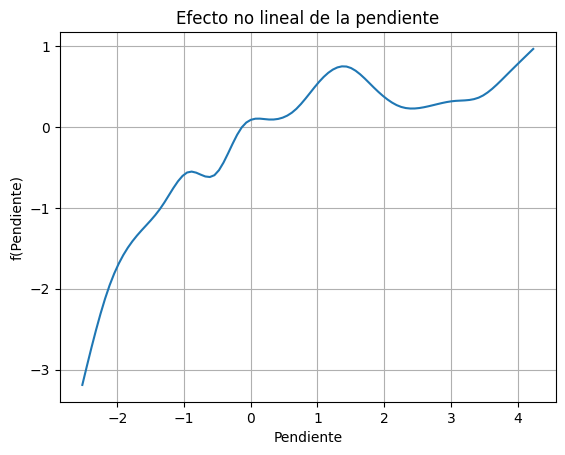

In [85]:
# Visualizaci√≥n del efecto de la pendiente
plt.figure()
plt.title("Efecto no lineal de la pendiente")
XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
plt.xlabel("Pendiente")
plt.ylabel("f(Pendiente)")
plt.grid(True)
plt.show()

#### Modelos No-Param√©tricos

##### *Support Vector Machine (SVM)*

SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo m√°s amplios posibles mediante un hiperplano de separaci√≥n definido como el vector entre los 2 puntos, de las 2 clases, m√°s cercanos al que se llama vector soporte. Cuando las nuevas muestras se ponen en correspondencia con dicho modelo, en funci√≥n de los espacios a los que pertenezcan, pueden ser clasificadas a una o la otra clase.

Los vectores de soporte son los puntos que definen el margen m√°ximo de separaci√≥n del hiperplano que separa las clases. Se llaman vectores, en lugar de puntos, porque estos ¬´puntos¬ª tienen tantos elementos como dimensiones tenga nuestro espacio de entrada. Es decir, estos puntos multi-dimensionales se representan con con vector de n dimensiones.

:::{figure-md} svm
<img src="https://i.pinimg.com/736x/15/e8/b0/15e8b0954323dc7bc6164ba7e23d8f4e.jpg" alt="svm" width="400px">

Intrepretaci√≥n geom√©trica de SVM.
:::

El *Maximal Margin Classifier* tiene poca aplicaci√≥n pr√°ctica, ya que rara vez se encuentran casos en los que las clases sean perfecta y linealmente separables. De hecho, incluso cumpli√©ndose estas condiciones ideales, en las que exista un hiperplano capaz de separar perfectamente las observaciones en dos clases, esta aproximaci√≥n sigue presentando dos inconvenientes:

* Dado que el hiperplano tiene que separar perfectamente las observaciones, es muy sensible a variaciones en los datos. Incluir una nueva observaci√≥n puede suponer cambios muy grandes en el hiperplano de separaci√≥n (poca robustez).

* Que el maximal margin hyperplane se ajuste perfectamente a las observaciones de entrenamiento para separarlas todas correctamente suele conllevar problemas de overfitting.

Por estas razones, es preferible crear un clasificador basado en un hiperplano que, aunque no separe perfectamente las dos clases, sea m√°s robusto y tenga mayor capacidad predictiva al aplicarlo a nuevas observaciones (menos problemas de overfitting). Esto es exactamente lo que consiguen los clasificadores de vector soporte, tambi√©n conocidos como soft margin classifiers o Support Vector Classifiers. Para lograrlo, en lugar de buscar el margen de clasificaci√≥n m√°s ancho posible que consigue que las observaciones est√©n en el lado correcto del margen; se permite que ciertas observaciones est√©n en el lado incorrecto del margen o incluso del hiperplano (Tomado de [cienciadedatos.net](https://www.cienciadedatos.net/documentos/34_maquinas_de_vector_soporte_support_vector_machines)).

###### *Python*

Similar a lso casos anteriores, se importa la librear√≠a de SVC, y se instancia. En este caso se utlizar√° un kernel lineal y un valor de regularizacion de 1xE10. Existen otra serie de hiperpar√°metros para instanciar el modelo que se pueden consultar en la [gu√≠a del usuario](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10)

Si se utiliza toda la base de datos, los resultados obtenidos clasifican todas las celdas con valores muy bajos. Esto se debe a que se utiliz√≥ para el entrenamiento la matriz desbalanceada, es decir con las celdas del *si* (1) y con todas las celdas del *no* (0). Lo que genera que el modelo no aprenda adecuadamente a predecir los *si*, ya que aprende esencialmente el *no*.

Como este m√©todo no tiene un hiperpar√°metro para manejar esta situaci√≥n, como RL, entonces debemos remuestrear nuestros datos de entrenamiento de tal forma que se reduzca el desbalance. En este caso utilizaremos el 1% de los *no*.

In [ ]:
df1=df[(df["inventario"]==1) | (df["inventario"]==0).sample(frac=0.01)]
X_01=df1.drop("inventario", axis=1)
y_01=df1['inventario']
df1['inventario'].value_counts()

0.0    9090
1.0    1620
Name: inventario, dtype: int64

El proceso a continuaci√≥n toma un tiempo considerable, de acuerdo con la capacidad computacional o el ambiente de trabajo que est√© utilizando (cuantas celdas tiene su base de datos?...entonces paciencia...o remuestree sus datos).

In [ ]:
model.fit(X_01,y_01)

In [ ]:
IS_01 = model.predict(x_map)

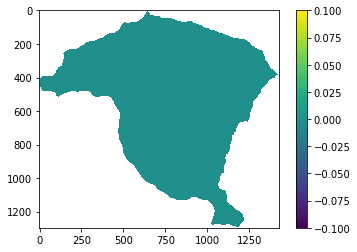

In [ ]:
IS_01=IS_01.reshape(pendiente.shape)
IS_01=np.where(pendiente<0,np.nan,IS_01)
plt.imshow(IS_01)
plt.colorbar();

Como se puede observar, el modelo ya tiene capacidad para predecir los *si* (1).

##### *Random forest*
Los √°rboles de decisi√≥n tienen la tendencia de sobre-ajustar (overfit). Esto quiere decir que tienden a aprender muy bien los datos de entrenamiento pero su generalizaci√≥n no es tan buena. Una forma de mejorar la generalizaci√≥n de los √°rboles de decisi√≥n es usar regularizaci√≥n. Para mejorar mucho m√°s la capacidad de generalizaci√≥n de los √°rboles de decisi√≥n, deberemos combinar varios √°rboles.

Un Random Forest es un conjunto (ensemble) de √°rboles de decisi√≥n combinados con bagging. Al usar bagging, lo que en realidad est√° pasando, es que distintos √°rboles ven distintas porciones de los datos. Ning√∫n √°rbol ve todos los datos de entrenamiento. Esto hace que cada √°rbol se entrene con distintas muestras de datos para un mismo problema. De esta forma, al combinar sus resultados, unos errores se compensan con otros y tenemos una predicci√≥n que generaliza mejor (Tomado de [iartificial.net](https://www.iartificial.net/random-forest-bosque-aleatorio/)).

:::{figure-md} rf
<img src="https://www.tibco.com/sites/tibco/files/media_entity/2021-05/random-forest-diagram.svg" alt="rf" width="400px">

Intrepretaci√≥n geom√©trica de *random forest**
:::

###### *Python*

De forma similar se importa la librear√≠a, y se instancia con los [hiperpar√°metros](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) deseados. Igualmente se trabajar√° solo con el 1% de las celdas del *si* (1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators= 1000)

In [ ]:
rf.fit(X_01, y_01);

In [ ]:
IS_01=rf.predict(x_map)

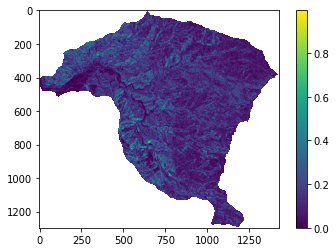

In [ ]:
IS_01=IS_01.reshape(pendiente.shape)
IS_01=np.where(pendiente<0,np.nan,IS_01)
plt.imshow(IS_01)
plt.colorbar();

El modelo de *random forest* permite obtener la importancia de las variables. A continuaci√≥n se presenta el c√≥digo para eso:

In [ ]:
print(list(rf.feature_importances_))

[0.47517109325806123, 0.48043670293880586, 0.04439220380313297]


##### Redes neuronales
Una red neuronal artificial es un grupo interconectado de nodos similar a la vasta red de neuronas en un cerebro biol√≥gico. Cada nodo circular representa una neurona artificial y cada flecha representa una conexi√≥n desde la salida de una neurona a la entrada de otra.

:::{figure-md} rna
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Colored_neural_network_es.svg/300px-Colored_neural_network_es.svg.png" alt="rna" width="400px">

Intrepretaci√≥n geom√©trica de redes neuronales. Tomado de [Wikipedia](https://es.wikipedia.org/wiki/Red_neuronal_artificial)
:::

Cada neurona est√° conectada con otras a trav√©s de unos enlaces. En estos enlaces el valor de salida de la neurona anterior es multiplicado por un valor de peso. Estos pesos en los enlaces pueden incrementar o inhibir el estado de activaci√≥n de las neuronas adyacentes. Del mismo modo, a la salida de la neurona, puede existir una funci√≥n limitadora o umbral, que modifica el valor resultado o impone un l√≠mite que no se debe sobrepasar antes de propagarse a otra neurona. Esta funci√≥n se conoce como funci√≥n de activaci√≥n. Estos sistemas aprenden y se forman a s√≠ mismos, en lugar de ser programados de forma expl√≠cita. Para realizar este aprendizaje autom√°tico, normalmente, se intenta minimizar una funci√≥n de p√©rdida que eval√∫a la red en su total. Los valores de los pesos de las neuronas se van actualizando buscando reducir el valor de la funci√≥n de p√©rdida. Este proceso se realiza mediante la propagaci√≥n hacia atr√°s.

###### *Python*

La librear√≠a *sklearn* permite implementar el *Multi-layer Perceptron classifier* (MLP). Para redes neuronales mas complejas se deben utilizar otras librear√≠as como TensorFlow. Sin embargo MLP permite un importante n√∫mero de [hiperpar√°metros](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), tales como el n√∫mero de capas escondidas y el n√∫mero de neuronas en cada una, asi como el n√∫mero de iteracciones que deseamos realice la RNA.

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(5,2),max_iter=500)  # dos capas escondidas, la primera con 5 neuronas y la segunda con dos neuronas
mlp

MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=500)

Para RNA es importante escalar las variables, para esto utilizamos la funci√≥n *StandarScaler*:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_01)
X_trans = scaler.transform(X_01)

Finlamente, se entrena el modelo y se predeci.

In [ ]:
mlp.fit(X_01,y_01)

MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=500)

In [ ]:
IS=mlp.predict(x_map)

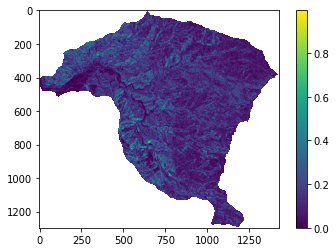

In [ ]:
IS_01=IS_01.reshape(pendiente.shape)
IS_01=np.where(pendiente<0,np.nan,IS_01)
plt.imshow(IS_01)
plt.colorbar();

## Referencias
```{bibliography}
:style: plain
:filter: docname in docnames
```